In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import os

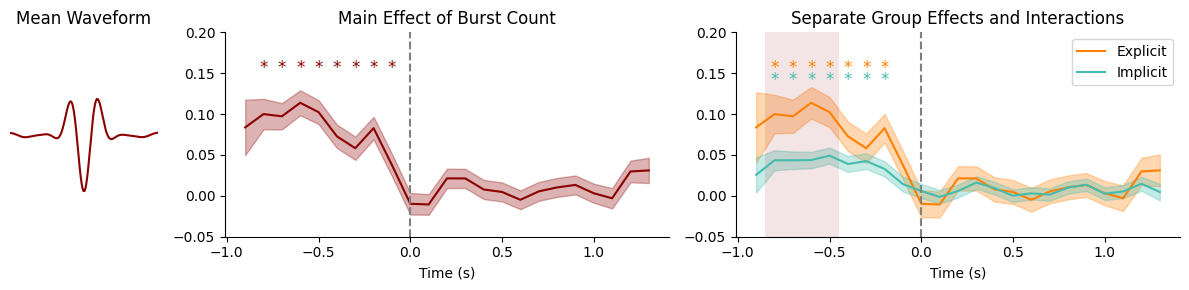

In [2]:
warnings.filterwarnings("ignore")

# File paths
waveform_file_path = '/home/qmoreau/Documents/Beta_bursts/Burst files/processed_waveforms.pkl'
waveform_time_path = '/home/qmoreau/Documents/Beta_bursts/Burst files/waveform_time.npy'

# Load waveform data
with open(waveform_file_path, "rb") as f:
    wvfrms = pickle.load(f)

waveform_time = np.load(waveform_time_path)

# Define PC key
pc_key = "PC_7"

# Define color palettes
adapt1 = sns.color_palette("Set1", n_colors=9)
colors1 = sns.color_palette("mako_r", n_colors=10)
colorbl = [adapt1[4], colors1[2]]  

# Time windows
start, end, step = -1, 1.3, 0.1
start_2, end_2 = -0.8, 1.5
window_start = np.arange(start, end, step)
window_end = np.arange(start_2, end_2, step)

def load_and_combine_data(pc_key, window_start, window_end):
    all_data = {}

    for i in range(len(window_start)):
        current_window_start = window_start[i]
        current_window_end = window_end[i]
        current_window_mid = current_window_start + 0.5 * (current_window_end - current_window_start)

        combined_data = pd.DataFrame()

        for q in range(4):  # Loop through quartiles
            current_window_start_str = f"{current_window_start:.3f}".rstrip('0').rstrip('.')
            current_window_end_str = f"{current_window_end:.3f}".rstrip('0').rstrip('.')
            if current_window_start_str == '-0': current_window_start_str = '0'
            if current_window_end_str == '-0': current_window_end_str = '0'

            file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{current_window_start_str}_{current_window_end_str}.csv'

            if os.path.exists(file_path):
                data = pd.read_csv(file_path)
                data = data[(data['block'] > 0) & (data['block'] < 7)]
                data['log_rt'] = np.log10(data['reach_rt'])
                data = data.dropna(subset=['reach_vis_abs_err', 'burst_count', 'group', 'subject'])

                # Rename burst_count and sum across quartiles per subject
                data = data.rename(columns={'burst_count': 'burst_count_q'})
                data = data.groupby(['subject', 'group', 'reach_rt', 'reach_vis_abs_err', 'coh_cat', 'block'], as_index=False).agg({'burst_count_q': 'sum'})
                data = data.rename(columns={'burst_count_q': 'all_bursts'})

                combined_data = pd.concat([combined_data, data], ignore_index=True)
            else:
                print(f"File not found: {file_path}")

        if not combined_data.empty:
            all_data[current_window_mid] = combined_data

    return all_data

# Load and combine data
combined_data_dict = load_and_combine_data(pc_key, window_start, window_end)

# Get mean waveform
mean_waveform = np.mean(wvfrms[pc_key], axis=0)  # Compute mean across quartiles

# Prepare figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 3, 3]})
fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax_waveform, ax_main, ax_interaction = axes

main_effect_data = []
explicit_effect_data = []
implicit_effect_data = []
significant_interactions = []

for window_mid, data in combined_data_dict.items():
    try:
        # Ensure subject is a categorical variable
        data["subject"] = data["subject"].astype("category")

        # Mixed Model with burst_count * group interaction
        model_main = smf.mixedlm("reach_vis_abs_err ~ all_bursts * group", 
                                 data, 
                                 groups=data["subject"], 
                                 re_formula="~1")  # Random intercept only
        model_main_fit = model_main.fit()

        # Extract main effect of burst_count
        main_effect_data.append({
            "window": window_mid,
            "Estimate": model_main_fit.params.get("all_bursts", np.nan),
            "SE": model_main_fit.bse.get("all_bursts", np.nan),
            "p_value": model_main_fit.pvalues.get("all_bursts", np.nan),
        })

        # Extract interaction effect significance
        interaction_p_value = model_main_fit.pvalues.get("all_bursts:group[T.Implicit]", np.nan)
                
        if interaction_p_value < 0.05:  # Check for significance
            significant_interactions.append({
                "window": window_mid,
                "p_value": interaction_p_value
            })

        # Separate models for Explicit and Implicit groups
        for group, effect_data in zip(["Explicit", "Implicit"], [explicit_effect_data, implicit_effect_data]):
            data_group = data[data["group"] == group]
            if not data_group.empty:
                model_group = smf.mixedlm("reach_vis_abs_err ~ all_bursts", 
                                          data_group, 
                                          groups=data_group["subject"], 
                                          re_formula="~1")  
                model_group_fit = model_group.fit()

                effect_data.append({
                    "window": window_mid,
                    "Estimate": model_group_fit.params.get("all_bursts", np.nan),
                    "SE": model_group_fit.bse.get("all_bursts", np.nan),
                    "p_value": model_group_fit.pvalues.get("all_bursts", np.nan),
                })

    except Exception as e:
        print(f"Error processing window {window_mid}: {e}")


# Filter significant windows for explicit and implicit groups
for group_data in [explicit_effect_data, implicit_effect_data]:
    if len(group_data) > 0:
        significant_windows = [item["window"] for item in group_data if item["p_value"] < 0.05 / 4]
        
        if len(significant_windows) > 0:
            sorted_windows = sorted(significant_windows)
            
            for item in group_data:
                if item["p_value"] < 0.05 / 4:
                    window = item["window"]
                    # Check if this window is part of a consecutive sequence
                    is_consecutive = False
                    
                    # Find index of current window in sorted list
                    if window in sorted_windows:
                        idx = sorted_windows.index(window)
                        
                        # Check if previous window is also significant
                        if idx > 0 and abs(window - sorted_windows[idx-1] - step) < 0.001:
                            is_consecutive = True
                        
                        # Check if next window is also significant
                        if idx < len(sorted_windows)-1 and abs(sorted_windows[idx+1] - window - step) < 0.001:
                            is_consecutive = True
                    
                    # Only mark as significant if part of a consecutive sequence
                    if not is_consecutive:
                        item["annotate"] = ""


# Convert to DataFrames
main_effect_df = pd.DataFrame(main_effect_data)
explicit_effect_df = pd.DataFrame(explicit_effect_data)
implicit_effect_df = pd.DataFrame(implicit_effect_data)

# Extract windows with significant interactions
significant_interaction_windows = [item["window"] for item in significant_interactions]

# Plot waveform
ax_waveform.set_ylim(-16, 16)
ax_waveform.set_xlim(-0.13, 0.13)
ax_waveform.plot(waveform_time, mean_waveform * 1e14, color="darkred", label="Mean Waveform")
ax_waveform.set_title("Mean Waveform")
# remove spines
ax_waveform.spines['right'].set_visible(False)
ax_waveform.spines['top'].set_visible(False)
ax_waveform.spines['left'].set_visible(False)
ax_waveform.spines['bottom'].set_visible(False)
ax_waveform.set_xticks([])
ax_waveform.set_yticks([])

# Plot Main Effect
ax_main.plot(main_effect_df["window"], main_effect_df["Estimate"], color="darkred", label="Main Effect")
ax_main.fill_between(
    main_effect_df["window"],
    main_effect_df["Estimate"] - main_effect_df["SE"],
    main_effect_df["Estimate"] + main_effect_df["SE"],
    alpha=0.3, color="darkred"
)

# Shifted stars for significance
for idx, row in main_effect_df.iterrows():
    if row["p_value"] < 0.05 / 4:
        ax_main.text(row["window"], 0.15, "*", color="darkred", fontsize=12, ha="center")

ax_main.axvline(0, linestyle="--", color="grey")
ax_main.set_title("Main Effect of Burst Count")
ax_main.set_xlabel("Time (s)")
ax_main.set_ylim(-0.05, 0.2)

# remove top and right spines
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)

# Plot Separate Group Effects (shifted stars)
for i, (group_df, label, color, y_offset) in enumerate(zip(
        [explicit_effect_df, implicit_effect_df],
        ["Explicit", "Implicit"],
        colorbl,
        [0.15, 0.135])):  

    ax_interaction.plot(group_df["window"], group_df["Estimate"], color=color, label=label)
    ax_interaction.fill_between(
        group_df["window"],
        group_df["Estimate"] - group_df["SE"],
        group_df["Estimate"] + group_df["SE"],
        alpha=0.3, color=color
    )

    for idx, row in group_df.iterrows():
        if row["p_value"] < 0.05/2:
            ax_interaction.text(row["window"], y_offset, "*", color=color, fontsize=12, ha="center")

# Add shading for significant interactions
if significant_interaction_windows:
    # Sort windows to ensure proper consecutive grouping
    significant_interaction_windows.sort()
    
    # Group consecutive windows
    groups = []
    current_group = [significant_interaction_windows[0]]
    
    for i in range(1, len(significant_interaction_windows)):
        if abs(significant_interaction_windows[i] - significant_interaction_windows[i-1] - step) < 0.001:
            current_group.append(significant_interaction_windows[i])
        else:
            groups.append(current_group)
            current_group = [significant_interaction_windows[i]]
    
    groups.append(current_group)
    
    # Add shaded areas only for groups with at least two consecutive significant windows
    for group in groups:
        if len(group) >= 2:  # Only shade if there are at least 2 consecutive windows
            # Calculate the width of a single window
            half_width = step / 2
            
            # Shade from the start of the first window to the end of the last window
            start_x = group[0] - half_width
            end_x = group[-1] + half_width
            
            # Add shaded area
            ax_interaction.axvspan(start_x, end_x, alpha=0.1, color='darkred', linewidth=0)

ax_interaction.axvline(0, linestyle="--", color="grey")
ax_interaction.set_title("Separate Group Effects and Interactions")
ax_interaction.set_xlabel("Time (s)")
ax_interaction.legend()
ax_interaction.set_ylim(-0.05, 0.2)

# remove top and right spines
ax_interaction.spines['right'].set_visible(False)
ax_interaction.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

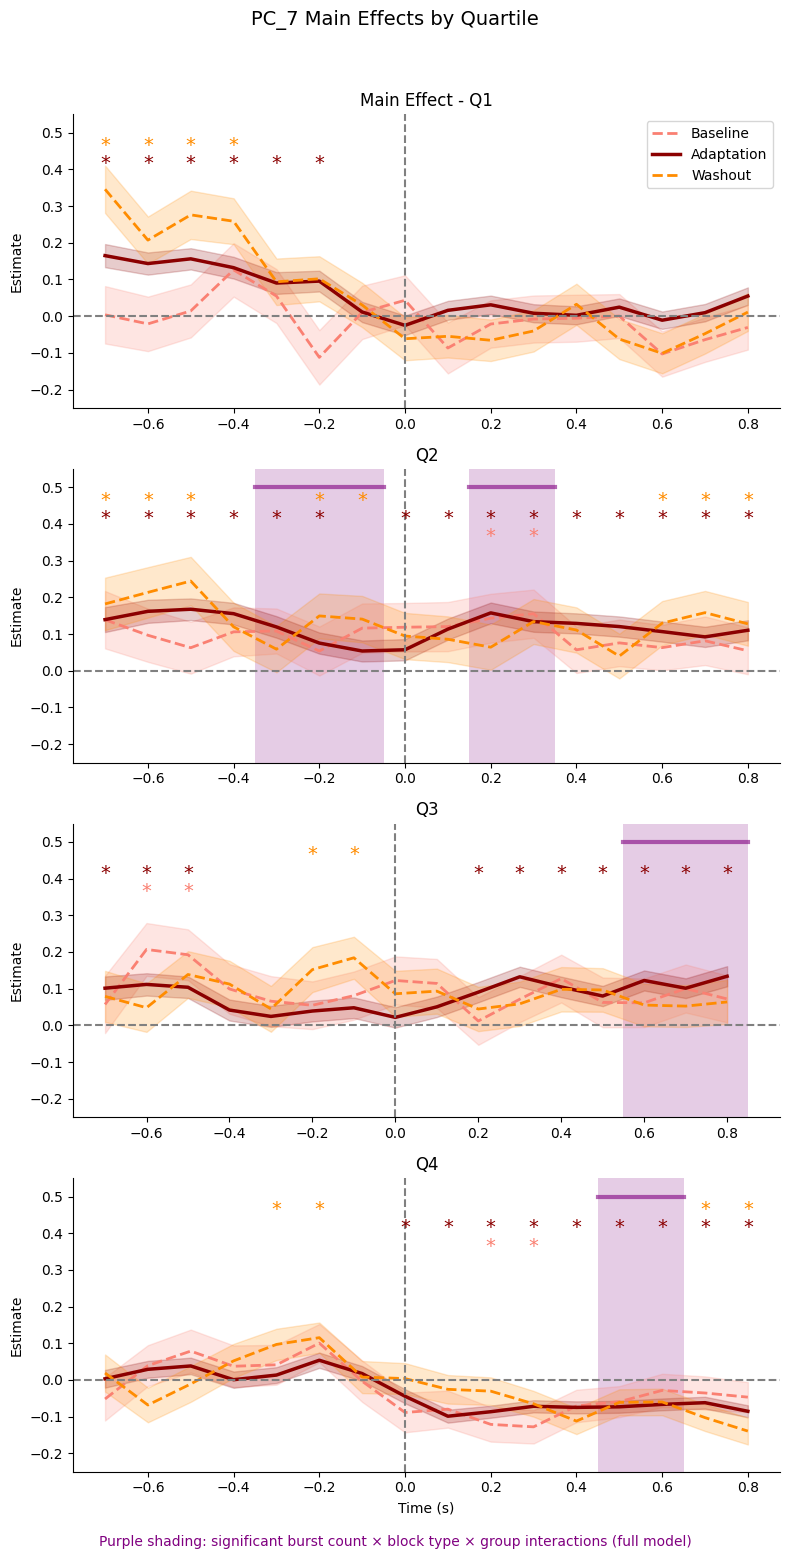

In [3]:
warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define color palettes
adapt1 = sns.color_palette("Set1", n_colors=9)
colors1 = sns.color_palette("mako_r", n_colors=10)
colorbl = [adapt1[4], colors1[2]]

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Initialize variables for time windows
start, end, step = -0.8, 0.8, 0.1
start_2, end_2 = -0.6, 1
window_start = np.arange(start, end, step)
window_end = np.arange(start_2, end_2, step)

# Prepare figure for 4x1 grid of plots (single column)
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 16)
)
fig.subplots_adjust(hspace=0.3)

# Define block colors
block_colors = ['salmon', 'darkred', 'darkorange']  # salmon for baseline, darkred for adaptation, darkorange for washout

# Loop through each quartile
col_r = plt.cm.cool(np.linspace(0, 1, num=4))
for q in range(4):
    # Dictionaries to store data for each block type - only main effects
    block_data = {block_name: {"main_effect": []} for block_name in block_types.keys()}
    
    # For each quartile, create a dictionary to store combined data across block types for each time window
    combined_window_data = {}
    
    # Process data for each block type and time window
    for block_name, block_num in block_types.items():
        for i in range(len(window_start)):
            current_window_start = window_start[i]
            current_window_end = window_end[i]
            current_window_mid = current_window_start + 0.5 * (current_window_end - current_window_start)

            # Format window values for file naming
            formatted_start = f"{current_window_start:.3f}".rstrip('0').rstrip('.')
            formatted_end = f"{current_window_end:.3f}".rstrip('0').rstrip('.')
            if formatted_start == '-0': formatted_start = '0'
            if formatted_end == '-0': formatted_end = '0'

            # File path for the current quartile and time window
            file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

            try:
                # Load data
                data = pd.read_csv(file_path)
                
                # Handle different block type conditions
                if block_name == "Adaptation":
                    data = data[data['block'].isin(block_num)]
                else:
                    data = data[data['block'] == block_num]
                
                data['log_rt'] = np.log10(data['reach_rt'])
                data['block_type'] = block_name
                
                data = data.reset_index(drop=True)
                data["subject"] = data["subject"].astype("category")
                data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])

                # ---------- MAIN EFFECT MODEL ----------
                model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count",
                    data,
                    groups=data["subject"]
                )
                model_fit = model.fit()

                # Extract results for main effect
                coef = model_fit.params
                stderr = model_fit.bse

                # Store main effect results
                block_data[block_name]["main_effect"].append({
                    "window": current_window_mid,
                    "Estimate": coef.get("burst_count", np.nan),
                    "SE": stderr.get("burst_count", np.nan),
                    "p_value": model_fit.pvalues.get("burst_count", np.nan),
                })

                # ---------- TRIPLE INTERACTION DATA COLLECTION ----------
                # Store data for combined model (across block types)
                window_key = f"{formatted_start}_{formatted_end}"
                if window_key not in combined_window_data:
                    combined_window_data[window_key] = {
                        "data": [],
                        "window_mid": current_window_mid
                    }
                
                # Add this block's data to the combined dataset
                combined_window_data[window_key]["data"].append(data)

            except FileNotFoundError:
                pass
    
    # Analyze the triple interaction using only the full model
    triple_interaction_results = []
    
    for window_key, window_info in combined_window_data.items():
        if len(window_info["data"]) > 1:  # Need at least 2 block types to test interaction
            # Combine data from all available block types for this time window
            combined_data = pd.concat(window_info["data"], ignore_index=True)
            
            try:
                # Check that we have at least two groups in the data
                if len(combined_data['group'].unique()) < 2:
                    continue
                
                # Ensure categorical variables are properly coded
                combined_data['group'] = combined_data['group'].astype('category')
                combined_data['block_type'] = combined_data['block_type'].astype('category')
                
                # Fit only the full model with triple interaction
                full_model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count * block_type * group", 
                    combined_data,
                    groups=combined_data["subject"]
                )
                full_fit = full_model.fit()
                
                # Extract triple interaction terms directly from the model results
                # Look for terms that contain all three variables
                triple_terms = [term for term in full_fit.pvalues.index 
                               if all(x in term for x in ["burst_count", "block_type", "group"]) 
                               and ":" in term]
                
                # Find the minimum p-value among all triple interaction terms
                if triple_terms:
                    # Get p-values for all triple interaction terms
                    triple_p_values = [full_fit.pvalues[term] for term in triple_terms]
                    min_p_value = min(triple_p_values)
                    
                    # For storing coefficient estimates
                    triple_estimates = {term: full_fit.params[term] for term in triple_terms}
                    triple_se = {term: full_fit.bse[term] for term in triple_terms}
                    
                    # Store results
                    triple_interaction_results.append({
                        "window_mid": window_info["window_mid"],
                        "p_value": min_p_value,
                        "triple_terms": triple_terms,
                        "estimates": triple_estimates,
                        "standard_errors": triple_se
                    })
                
            except Exception as e:
                print(f"Error in window {window_key}: {e}")
    
    # Convert to DataFrames for main effects
    for block_name in block_types.keys():
        block_data[block_name]["main_effect_df"] = pd.DataFrame(block_data[block_name]["main_effect"])
        # Sort by window time
        if not block_data[block_name]["main_effect_df"].empty:
            block_data[block_name]["main_effect_df"] = block_data[block_name]["main_effect_df"].sort_values("window")
    
    # Convert triple interaction results to DataFrame with just window and p-value for plotting
    triple_interaction_df = pd.DataFrame([
        {"window": res["window_mid"], "p_value": res["p_value"]}
        for res in triple_interaction_results
    ])
    
    # Sort by window time
    if not triple_interaction_df.empty:
        triple_interaction_df = triple_interaction_df.sort_values("window")
        # Apply Bonferroni correction for multiple comparisons across quartiles
        triple_interaction_df["significant"] = triple_interaction_df["p_value"] < (0.05 / 4)  # Correcting for 4 quartiles

    # Plot on the appropriate subplot position in the single column
    ax_main = axes[q]
    
    # Plot Main Effect with Triple Interaction highlights
    # Adaptation as solid line, baseline and washout as dashed
    line_styles = ['--', '-', '--']  # baseline dashed, adaptation solid, washout dashed
    line_widths = [2.0, 2.5, 2.0]
    
    # Plot main effects
    for idx, (block_name, block_info) in enumerate(block_data.items()):
        if not block_info["main_effect_df"].empty:
            # Plot the main effect lines
            ax_main.plot(
                block_info["main_effect_df"]["window"], 
                block_info["main_effect_df"]["Estimate"], 
                color=block_colors[idx], 
                linestyle=line_styles[idx],
                linewidth=line_widths[idx],
                label=f"{block_name}" if q == 0 else None
            )
            # Plot shaded error areas
            ax_main.fill_between(
                block_info["main_effect_df"]["window"],
                block_info["main_effect_df"]["Estimate"] - block_info["main_effect_df"]["SE"],
                block_info["main_effect_df"]["Estimate"] + block_info["main_effect_df"]["SE"],
                alpha=0.2,
                color=block_colors[idx]
            )
            
            # remove the top and right spines
            ax_main.spines['top'].set_visible(False)
            ax_main.spines['right'].set_visible(False)
            
            # Find consecutive significant time windows for main effects
            df = block_info["main_effect_df"]
            if not df.empty and len(df) > 1:
                # Initialize the significant windows list
                sig_windows = []
                
                # Create a list of window indices where p < 0.05
                sig_indices = df.index[df["p_value"] < 0.05].tolist()
                
                # Find consecutive runs
                if sig_indices:
                    # Start with the first significant index
                    current_run = [sig_indices[0]]
                    
                    # Go through the rest of the significant indices
                    for i in range(1, len(sig_indices)):
                        # If this index follows the previous one, extend the current run
                        if sig_indices[i] == sig_indices[i-1] + 1:
                            current_run.append(sig_indices[i])
                        else:
                            # If the run has 2 or more consecutive windows, store it
                            if len(current_run) >= 2:
                                sig_windows.append(current_run)
                            # Start a new run
                            current_run = [sig_indices[i]]
                    
                    # Don't forget to add the last run if it's valid
                    if len(current_run) >= 2:
                        sig_windows.append(current_run)
                
                # Add significance markers only for consecutive windows
                for run in sig_windows:
                    # Get the actual window values for these indices
                    run_windows = df.iloc[run]["window"].values
                    # Add star for each window in the run
                    for w in run_windows:
                        y_pos = 0.35 + (0.05 * idx)  # Offset to avoid overlap
                        ax_main.text(w, y_pos, "*", color=block_colors[idx], fontsize=14, ha='center')
    
    # Handle triple interaction effects - find consecutive significant windows
    if not triple_interaction_df.empty and len(triple_interaction_df) > 1:
        # Sort by window value to ensure correct order
        triple_interaction_df = triple_interaction_df.sort_values("window").reset_index(drop=True)
        
        # Find runs of consecutive significant windows
        in_run = False
        current_run = []
        significant_runs = []
        
        for i, row in triple_interaction_df.iterrows():
            if row["significant"]:
                if not in_run:
                    # Start a new run
                    in_run = True
                    current_run = [row["window"]]
                else:
                    # Continue the current run
                    current_run.append(row["window"])
            else:
                # End the current run if it has enough windows
                if in_run:
                    # Only store runs with 2+ consecutive windows
                    if len(current_run) >= 2:
                        significant_runs.append(current_run)
                    in_run = False
                    current_run = []
        
        # Don't forget to check the last run
        if in_run and len(current_run) >= 2:
            significant_runs.append(current_run)
        
        # Add purple shaded areas only for runs of consecutive significant windows
        for run in significant_runs:
            # Shade from the start of the first window to the end of the last window
            ax_main.axvspan(
                min(run) - 0.05,  # Start slightly before
                max(run) + 0.05,  # End slightly after
                alpha=0.2,
                color='purple',
                zorder=0,
                linewidth=0,
                edgecolor='none'
            )
            
            # Add a purple line at the top to indicate significant triple interaction
            y_pos = 0.5  # Position at the top of the plot
            # Draw a line spanning the significant window range
            ax_main.plot(
                [min(run) - 0.05, max(run) + 0.05],
                [y_pos, y_pos],
                color='purple',
                linewidth=3,
                alpha=0.6
            )
    
    ax_main.axvline(0, linestyle="--", color="grey")
    ax_main.axhline(0, linestyle="--", color="grey")
    ax_main.set_title(f"Main Effect - Q{q+1}" if q == 0 else f"Q{q+1}")
    ax_main.set_ylim(-0.25, 0.55)
    
    # Add x-axis labels only to the bottom subplot
    if q == 3:
        ax_main.set_xlabel("Time (s)")
    
    # Add y-axis label to all subplots
    ax_main.set_ylabel("Estimate")
    
    # Add legend to the first subplot only
    if q == 0:
        ax_main.legend(fontsize=10, loc="upper right")

# Add a note about the purple shaded areas and lines
fig.text(0.5, 0.02, "Purple shading: significant burst count × block type × group interactions (full model)", 
         ha='center', fontsize=10, color='purple')

# Add a common title for all subplots
plt.suptitle(f"{pc_key} Main Effects by Quartile", fontsize=14, y=0.98)

# Display all plots
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

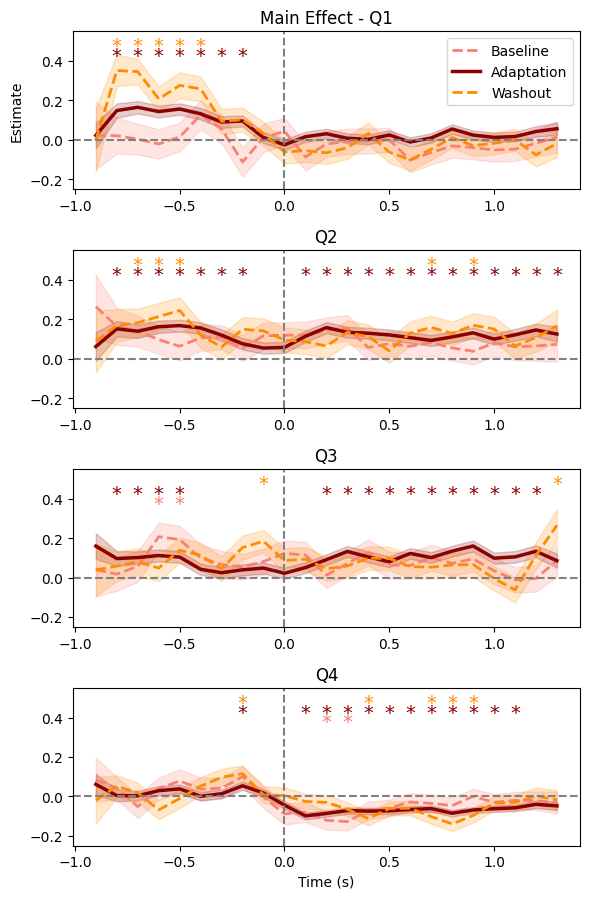

In [4]:
warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define color palettes
adapt1 = sns.color_palette("Set1", n_colors=9)
colors1 = sns.color_palette("mako_r", n_colors=10)
colorbl = [adapt1[4], colors1[2]]

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Initialize variables for time windows
start, end, step = -1, 1.3, 0.1
start_2, end_2 = -0.8, 1.5
window_start = np.arange(start, end, step)
window_end = np.arange(start_2, end_2, step)

# Prepare figure for single column of plots - removed waveform column
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(6, 10)
)
fig.subplots_adjust(hspace=0.6)

# Define new block colors as requested
block_colors = ['salmon', 'darkred', 'darkorange']  # salmon for baseline, darkred for adaptation, moccasin for washout

# Loop through each quartile
col_r = plt.cm.cool(np.linspace(0, 1, num=4))  # Generate consistent colors for quartiles
for q in range(4):
    # Dictionaries to store data for each block type - only main effects
    block_data = {block_name: {"main_effect": []} for block_name in block_types.keys()}
    
    # Waveform generation removed

    # Process data for each block type and time window
    for block_name, block_num in block_types.items():
        for i in range(len(window_start)):
            current_window_start = window_start[i]
            current_window_end = window_end[i]
            current_window_mid = current_window_start + 0.5 * (current_window_end - current_window_start)

            # Format window values for file naming
            formatted_start = f"{current_window_start:.3f}".rstrip('0').rstrip('.')
            formatted_end = f"{current_window_end:.3f}".rstrip('0').rstrip('.')
            if formatted_start == '-0': formatted_start = '0'
            if formatted_end == '-0': formatted_end = '0'

            # File path for the current quartile and time window
            file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

            try:
                # Load data
                data = pd.read_csv(file_path)
                
                # Handle different block type conditions
                if block_name == "Adaptation":
                    data = data[data['block'].isin(block_num)]
                else:
                    data = data[data['block'] == block_num]
                
                data['log_rt'] = np.log10(data['reach_rt'])
                data['block_type'] = block_name  # Add block type as a column

                data = data.reset_index(drop=True)
                data["subject"] = data["subject"].astype("category")
                data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])

                # Fit linear mixed-effects model for main effect only (not considering group interaction)
                model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count",
                    data,
                    groups=data["subject"]
                )
                model_fit = model.fit()

                # Extract results
                coef = model_fit.params
                stderr = model_fit.bse

                # Main effect
                block_data[block_name]["main_effect"].append({
                    "window": current_window_mid,
                    "Estimate": coef.get("burst_count", np.nan),
                    "SE": stderr.get("burst_count", np.nan),
                    "p_value": model_fit.pvalues.get("burst_count", np.nan),
                })

            except FileNotFoundError:
                print(f"File not found: {file_path}")
    
    # Convert to DataFrames - only main effects
    for block_name in block_types.keys():
        block_data[block_name]["main_effect_df"] = pd.DataFrame(block_data[block_name]["main_effect"])

    # Plot Main Effect Only - Comparison between baseline, adaptation, and washout
    ax_main = axes[q]
    # Adaptation as solid line, baseline and washout as dashed
    line_styles = ['--', '-', '--']  # baseline dashed, adaptation solid, washout dashed
    line_widths = [2.0, 2.5, 2.0]
    
    for idx, (block_name, block_info) in enumerate(block_data.items()):
        if not block_info["main_effect_df"].empty:
            ax_main.plot(
                block_info["main_effect_df"]["window"], 
                block_info["main_effect_df"]["Estimate"], 
                color=block_colors[idx], 
                linestyle=line_styles[idx],
                linewidth=line_widths[idx],
                label=f"{block_name}" if q == 0 else None
            )
            ax_main.fill_between(
                block_info["main_effect_df"]["window"],
                block_info["main_effect_df"]["Estimate"] - block_info["main_effect_df"]["SE"],
                block_info["main_effect_df"]["Estimate"] + block_info["main_effect_df"]["SE"],
                alpha=0.2,
                color=block_colors[idx]
            )
            
            # Add significance markers - now using stars (*) for all block types with block-specific colors
            for _, row in block_info["main_effect_df"].iterrows():
                if row["p_value"] < 0.05 / 4:
                    y_pos = 0.35 + (0.05 * idx)  # Offset to avoid overlap
                    ax_main.text(row["window"], y_pos, "*", color=block_colors[idx], fontsize=14, ha='center')
    
    ax_main.axvline(0, linestyle="--", color="grey")
    ax_main.axhline(0, linestyle="--", color="grey")
    ax_main.set_title(f"Main Effect - Q{q+1}" if q == 0 else f"Q{q+1}")
    ax_main.set_ylim(-0.25, 0.55)
    ax_main.set_xlabel("Time (s)" if q == 3 else "")
    ax_main.set_ylabel("Estimate" if q == 0 else "")
    if q == 0:
        ax_main.legend(fontsize=10, loc="upper right")

# Display all plots
plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Adjust for the suptitle and bottom legend
plt.show()

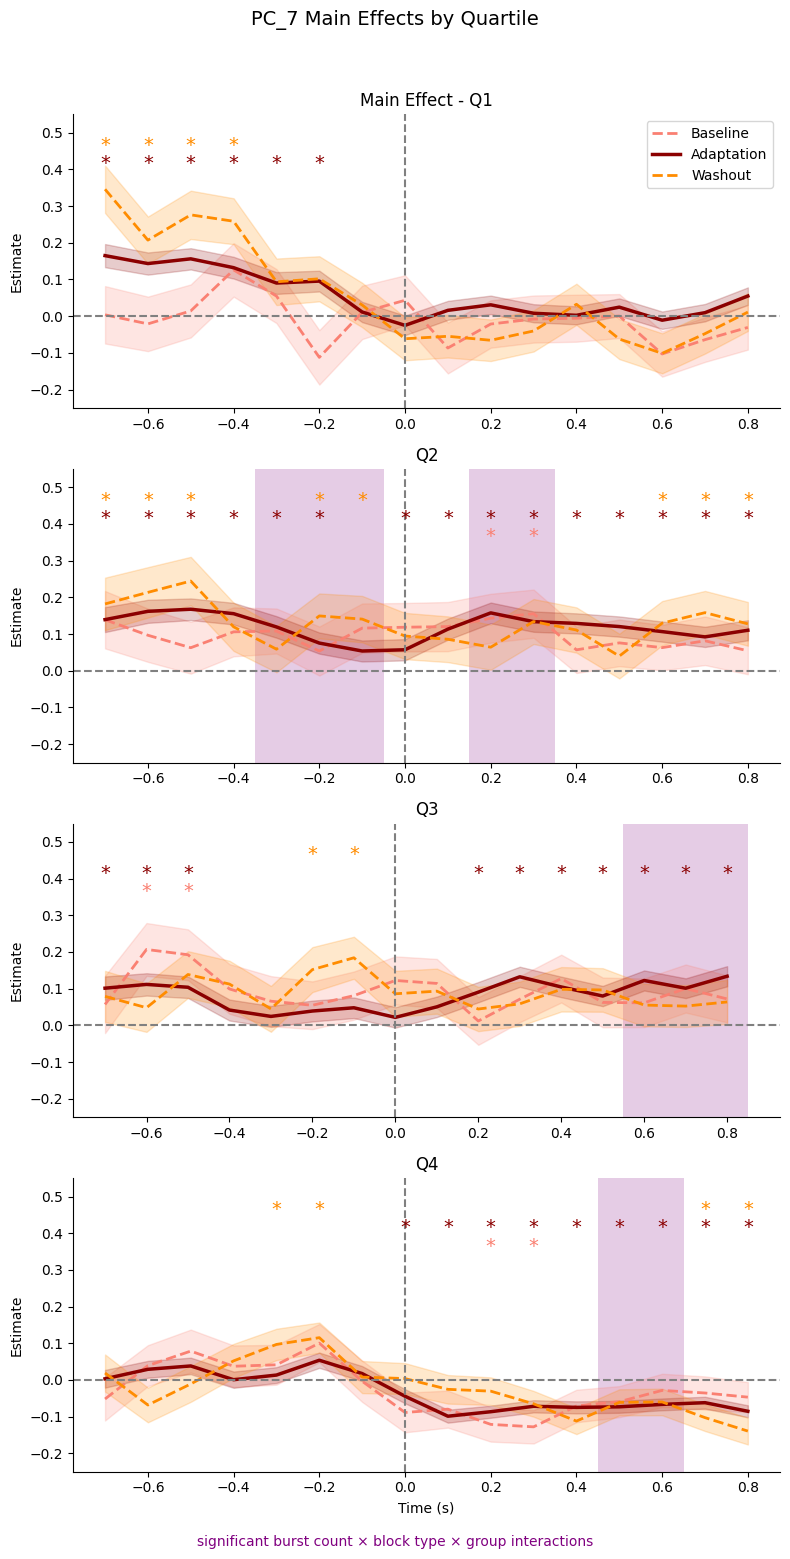

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define color palettes
adapt1 = sns.color_palette("Set1", n_colors=9)
colors1 = sns.color_palette("mako_r", n_colors=10)
colorbl = [adapt1[4], colors1[2]]

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Initialize variables for time windows
start, end, step = -0.8, 0.8, 0.1
start_2, end_2 = -0.6, 1
window_start = np.arange(start, end, step)
window_end = np.arange(start_2, end_2, step)

# Prepare figure for 4x1 grid of plots (single column)
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 16)
)
fig.subplots_adjust(hspace=0.3)

# Define block colors
block_colors = ['salmon', 'darkred', 'darkorange']  # salmon for baseline, darkred for adaptation, darkorange for washout

# Loop through each quartile
col_r = plt.cm.cool(np.linspace(0, 1, num=4))
for q in range(4):
    # Dictionaries to store data for each block type - only main effects
    block_data = {block_name: {"main_effect": []} for block_name in block_types.keys()}
    
    # For each quartile, create a dictionary to store combined data across block types for each time window
    combined_window_data = {}
    
    # Process data for each block type and time window
    for block_name, block_num in block_types.items():
        for i in range(len(window_start)):
            current_window_start = window_start[i]
            current_window_end = window_end[i]
            current_window_mid = current_window_start + 0.5 * (current_window_end - current_window_start)

            # Format window values for file naming
            formatted_start = f"{current_window_start:.3f}".rstrip('0').rstrip('.')
            formatted_end = f"{current_window_end:.3f}".rstrip('0').rstrip('.')
            if formatted_start == '-0': formatted_start = '0'
            if formatted_end == '-0': formatted_end = '0'

            # File path for the current quartile and time window
            file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

            try:
                # Load data
                data = pd.read_csv(file_path)
                
                # Handle different block type conditions
                if block_name == "Adaptation":
                    data = data[data['block'].isin(block_num)]
                else:
                    data = data[data['block'] == block_num]
                
                data['log_rt'] = np.log10(data['reach_rt'])
                data['block_type'] = block_name
                
                data = data.reset_index(drop=True)
                data["subject"] = data["subject"].astype("category")
                data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])

                # ---------- MAIN EFFECT MODEL ----------
                model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count",
                    data,
                    groups=data["subject"]
                )
                model_fit = model.fit()

                # Extract results for main effect
                coef = model_fit.params
                stderr = model_fit.bse

                # Store main effect results
                block_data[block_name]["main_effect"].append({
                    "window": current_window_mid,
                    "Estimate": coef.get("burst_count", np.nan),
                    "SE": stderr.get("burst_count", np.nan),
                    "p_value": model_fit.pvalues.get("burst_count", np.nan),
                })

                # ---------- TRIPLE INTERACTION DATA COLLECTION ----------
                # Store data for combined model (across block types)
                window_key = f"{formatted_start}_{formatted_end}"
                if window_key not in combined_window_data:
                    combined_window_data[window_key] = {
                        "data": [],
                        "window_mid": current_window_mid
                    }
                
                # Add this block's data to the combined dataset
                combined_window_data[window_key]["data"].append(data)

            except FileNotFoundError:
                pass
    
    # Run the triple interaction models on the combined data for each time window
    triple_interaction_results = []
    
    for window_key, window_info in combined_window_data.items():
        if len(window_info["data"]) > 1:  # Need at least 2 block types to test interaction
            # Combine data from all available block types for this time window
            combined_data = pd.concat(window_info["data"], ignore_index=True)
            
            try:
                # Check that we have at least two groups in the data
                if len(combined_data['group'].unique()) < 2:
                    continue
                
                # Ensure 'group' is properly treated as categorical
                combined_data['group'] = combined_data['group'].astype('category')
                
                # Fit model with triple interaction (burst_count × block_type × group)
                triple_interaction_model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count * block_type * group",
                    combined_data,
                    groups=combined_data["subject"]
                )
                triple_interaction_fit = triple_interaction_model.fit()
                
                # Extract the triple interaction terms - looking for terms with all three variables
                triple_interaction_terms = [term for term in triple_interaction_fit.pvalues.index 
                                          if "burst_count" in term and "block_type" in term and "group" in term and "burst_count" in term]
                
                # Get p-values for triple interaction terms
                if triple_interaction_terms:
                    min_p_value = min([triple_interaction_fit.pvalues[term] for term in triple_interaction_terms])
                else:
                    min_p_value = np.nan
                
                # Store results
                triple_interaction_results.append({
                    "window_mid": window_info["window_mid"],
                    "p_value": min_p_value
                })
                    
            except Exception as e:
                pass
    
    # Convert to DataFrames for main effects
    for block_name in block_types.keys():
        block_data[block_name]["main_effect_df"] = pd.DataFrame(block_data[block_name]["main_effect"])
        # Sort by window time
        if not block_data[block_name]["main_effect_df"].empty:
            block_data[block_name]["main_effect_df"] = block_data[block_name]["main_effect_df"].sort_values("window")
    
    # Convert triple interaction results to DataFrame
    triple_interaction_df = pd.DataFrame([
        {"window": res["window_mid"], "p_value": res["p_value"]}
        for res in triple_interaction_results
    ])
    
    # Sort by window time
    if not triple_interaction_df.empty:
        triple_interaction_df = triple_interaction_df.sort_values("window")

    # Plot on the appropriate subplot position in the single column
    ax_main = axes[q]
    
    # Plot Main Effect with Triple Interaction highlights
    # Adaptation as solid line, baseline and washout as dashed
    line_styles = ['--', '-', '--']  # baseline dashed, adaptation solid, washout dashed
    line_widths = [2.0, 2.5, 2.0]
    
    # Plot main effects
    for idx, (block_name, block_info) in enumerate(block_data.items()):
        if not block_info["main_effect_df"].empty:
            # Plot the main effect lines
            ax_main.plot(
                block_info["main_effect_df"]["window"], 
                block_info["main_effect_df"]["Estimate"], 
                color=block_colors[idx], 
                linestyle=line_styles[idx],
                linewidth=line_widths[idx],
                label=f"{block_name}" if q == 0 else None
            )
            # Plot shaded error areas
            ax_main.fill_between(
                block_info["main_effect_df"]["window"],
                block_info["main_effect_df"]["Estimate"] - block_info["main_effect_df"]["SE"],
                block_info["main_effect_df"]["Estimate"] + block_info["main_effect_df"]["SE"],
                alpha=0.2,
                color=block_colors[idx]
            )
            
            # remove the top and right spines
            ax_main.spines['top'].set_visible(False)
            ax_main.spines['right'].set_visible(False)
            
            # Find consecutive significant time windows for main effects
            df = block_info["main_effect_df"]
            if not df.empty and len(df) > 1:
                # Initialize the significant windows list
                sig_windows = []
                
                # Create a list of window indices where p < 0.05
                sig_indices = df.index[df["p_value"] < 0.05].tolist()
                
                # Find consecutive runs
                if sig_indices:
                    # Start with the first significant index
                    current_run = [sig_indices[0]]
                    
                    # Go through the rest of the significant indices
                    for i in range(1, len(sig_indices)):
                        # If this index follows the previous one, extend the current run
                        if sig_indices[i] == sig_indices[i-1] + 1:
                            current_run.append(sig_indices[i])
                        else:
                            # If the run has 2 or more consecutive windows, store it
                            if len(current_run) >= 2:
                                sig_windows.append(current_run)
                            # Start a new run
                            current_run = [sig_indices[i]]
                    
                    # Don't forget to add the last run if it's valid
                    if len(current_run) >= 2:
                        sig_windows.append(current_run)
                
                # Add significance markers only for consecutive windows
                for run in sig_windows:
                    # Get the actual window values for these indices
                    run_windows = df.iloc[run]["window"].values
                    # Add star for each window in the run
                    for w in run_windows:
                        y_pos = 0.35 + (0.05 * idx)  # Offset to avoid overlap
                        ax_main.text(w, y_pos, "*", color=block_colors[idx], fontsize=14, ha='center')
    
    # Handle triple interaction effects - find consecutive significant windows
    if not triple_interaction_df.empty and len(triple_interaction_df) > 1:
        # Sort by window value to ensure correct order
        triple_interaction_df = triple_interaction_df.sort_values("window").reset_index(drop=True)
        
        triple_interaction_df["significant"] = triple_interaction_df["p_value"] < 0.05 / 4
        
        # Find runs of consecutive significant windows
        significant_runs = []
        in_run = False
        current_run = []
        
        for i, row in triple_interaction_df.iterrows():
            if row["significant"]:
                if not in_run:
                    # Start a new run
                    in_run = True
                    current_run = [row["window"]]
                else:
                    # Continue the current run
                    current_run.append(row["window"])
                    
                # Check if we're at the end
                if i == len(triple_interaction_df) - 1 and len(current_run) >= 2:
                    significant_runs.append(current_run)
            else:
                # End the current run if it has enough windows
                if in_run and len(current_run) >= 2:
                    significant_runs.append(current_run)
                in_run = False
                current_run = []
        
        # Add purple shaded areas only for runs of consecutive significant windows
        for run in significant_runs:
            # Shade from the start of the first window to the end of the last window
            ax_main.axvspan(
                min(run) - 0.05,  # Start slightly before
                max(run) + 0.05,  # End slightly after
                alpha=0.2,
                color='purple',
                zorder=0,
                linewidth=0,
                edgecolor='none'
            )
    
    ax_main.axvline(0, linestyle="--", color="grey")
    ax_main.axhline(0, linestyle="--", color="grey")
    ax_main.set_title(f"Main Effect - Q{q+1}" if q == 0 else f"Q{q+1}")
    ax_main.set_ylim(-0.25, 0.55)
    
    # Add x-axis labels only to the bottom subplot
    if q == 3:
        ax_main.set_xlabel("Time (s)")
    
    # Add y-axis label to all subplots
    ax_main.set_ylabel("Estimate")
    
    # Add legend to the first subplot only
    if q == 0:
        ax_main.legend(fontsize=10, loc="upper right")

# Add a note about the purple shaded areas (now with consecutive window requirement)
fig.text(0.5, 0.02, "significant burst count × block type × group interactions", 
         ha='center', fontsize=10, color='purple')

# Add a common title for all subplots
plt.suptitle(f"{pc_key} Main Effects by Quartile", fontsize=14, y=0.98)

# Display all plots
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

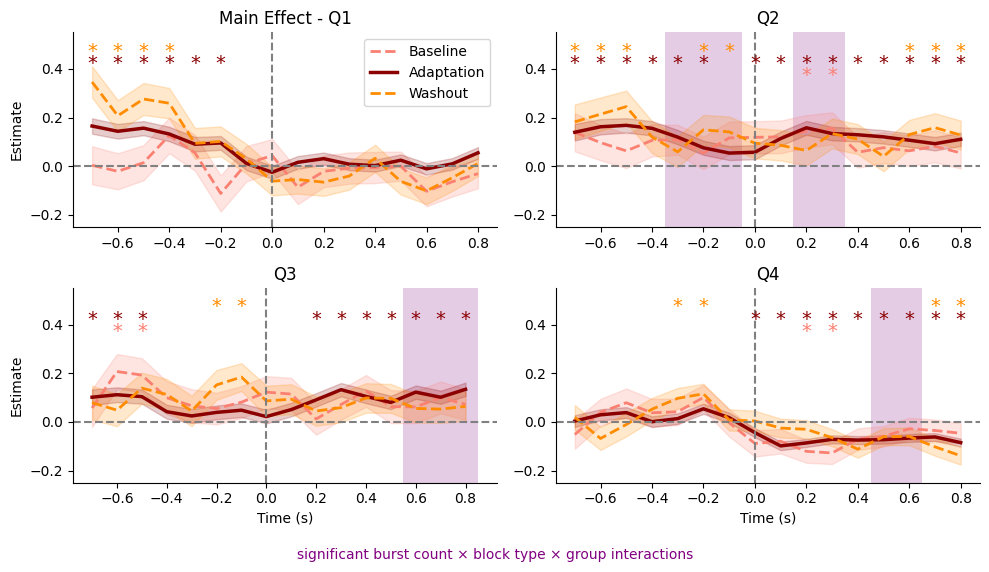

In [6]:

warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define color palettes
adapt1 = sns.color_palette("Set1", n_colors=9)
colors1 = sns.color_palette("mako_r", n_colors=10)
colorbl = [adapt1[4], colors1[2]]

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Initialize variables for time windows
start, end, step = -0.8, 0.8, 0.1
start_2, end_2 = -0.6, 1
window_start = np.arange(start, end, step)
window_end = np.arange(start_2, end_2, step)

# Prepare figure for 2x2 grid of plots
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 6)
)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Define block colors
block_colors = ['salmon', 'darkred', 'darkorange']  # salmon for baseline, darkred for adaptation, darkorange for washout

# Loop through each quartile
col_r = plt.cm.cool(np.linspace(0, 1, num=4))
for q in range(4):
    # Dictionaries to store data for each block type - only main effects
    block_data = {block_name: {"main_effect": []} for block_name in block_types.keys()}
    
    # For each quartile, create a dictionary to store combined data across block types for each time window
    combined_window_data = {}
    
    # Process data for each block type and time window
    for block_name, block_num in block_types.items():
        for i in range(len(window_start)):
            current_window_start = window_start[i]
            current_window_end = window_end[i]
            current_window_mid = current_window_start + 0.5 * (current_window_end - current_window_start)

            # Format window values for file naming
            formatted_start = f"{current_window_start:.3f}".rstrip('0').rstrip('.')
            formatted_end = f"{current_window_end:.3f}".rstrip('0').rstrip('.')
            if formatted_start == '-0': formatted_start = '0'
            if formatted_end == '-0': formatted_end = '0'

            # File path for the current quartile and time window
            file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

            try:
                # Load data
                data = pd.read_csv(file_path)
                
                # Handle different block type conditions
                if block_name == "Adaptation":
                    data = data[data['block'].isin(block_num)]
                else:
                    data = data[data['block'] == block_num]
                
                data['log_rt'] = np.log10(data['reach_rt'])
                data['block_type'] = block_name
                
                data = data.reset_index(drop=True)
                data["subject"] = data["subject"].astype("category")
                data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])

                # ---------- MAIN EFFECT MODEL ----------
                model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count",
                    data,
                    groups=data["subject"]
                )
                model_fit = model.fit()

                # Extract results for main effect
                coef = model_fit.params
                stderr = model_fit.bse

                # Store main effect results
                block_data[block_name]["main_effect"].append({
                    "window": current_window_mid,
                    "Estimate": coef.get("burst_count", np.nan),
                    "SE": stderr.get("burst_count", np.nan),
                    "p_value": model_fit.pvalues.get("burst_count", np.nan),
                })

                # ---------- TRIPLE INTERACTION DATA COLLECTION ----------
                # Store data for combined model (across block types)
                window_key = f"{formatted_start}_{formatted_end}"
                if window_key not in combined_window_data:
                    combined_window_data[window_key] = {
                        "data": [],
                        "window_mid": current_window_mid
                    }
                
                # Add this block's data to the combined dataset
                combined_window_data[window_key]["data"].append(data)

            except FileNotFoundError:
                pass
    
    # Run the triple interaction models on the combined data for each time window
    triple_interaction_results = []
    
    for window_key, window_info in combined_window_data.items():
        if len(window_info["data"]) > 1:  # Need at least 2 block types to test interaction
            # Combine data from all available block types for this time window
            combined_data = pd.concat(window_info["data"], ignore_index=True)
            
            try:
                # Check that we have at least two groups in the data
                if len(combined_data['group'].unique()) < 2:
                    continue
                
                # Ensure 'group' is properly treated as categorical
                combined_data['group'] = combined_data['group'].astype('category')
                
                # Fit model with triple interaction (burst_count × block_type × group)
                triple_interaction_model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count * block_type * group",
                    combined_data,
                    groups=combined_data["subject"]
                )
                triple_interaction_fit = triple_interaction_model.fit()
                
                # Extract the triple interaction terms - looking for terms with all three variables
                triple_interaction_terms = [term for term in triple_interaction_fit.pvalues.index 
                                          if "burst_count" in term and "block_type" in term and "group" in term and "burst_count" in term]
                
                # Get p-values for triple interaction terms
                if triple_interaction_terms:
                    min_p_value = min([triple_interaction_fit.pvalues[term] for term in triple_interaction_terms])
                else:
                    min_p_value = np.nan
                
                # Store results
                triple_interaction_results.append({
                    "window_mid": window_info["window_mid"],
                    "p_value": min_p_value
                })
                    
            except Exception as e:
                pass
    
    # Convert to DataFrames for main effects
    for block_name in block_types.keys():
        block_data[block_name]["main_effect_df"] = pd.DataFrame(block_data[block_name]["main_effect"])
        # Sort by window time
        if not block_data[block_name]["main_effect_df"].empty:
            block_data[block_name]["main_effect_df"] = block_data[block_name]["main_effect_df"].sort_values("window")
    
    # Convert triple interaction results to DataFrame
    triple_interaction_df = pd.DataFrame([
        {"window": res["window_mid"], "p_value": res["p_value"]}
        for res in triple_interaction_results
    ])
    
    # Sort by window time
    if not triple_interaction_df.empty:
        triple_interaction_df = triple_interaction_df.sort_values("window")

    # Determine subplot position (convert from 1D to 2D grid)
    row_idx = q // 2
    col_idx = q % 2
    ax_main = axes[row_idx, col_idx]
    
    # Plot Main Effect with Triple Interaction highlights
    # Adaptation as solid line, baseline and washout as dashed
    line_styles = ['--', '-', '--']  # baseline dashed, adaptation solid, washout dashed
    line_widths = [2.0, 2.5, 2.0]
    
    # Plot main effects
    for idx, (block_name, block_info) in enumerate(block_data.items()):
        if not block_info["main_effect_df"].empty:
            # Plot the main effect lines
            ax_main.plot(
                block_info["main_effect_df"]["window"], 
                block_info["main_effect_df"]["Estimate"], 
                color=block_colors[idx], 
                linestyle=line_styles[idx],
                linewidth=line_widths[idx],
                label=f"{block_name}" if q == 0 else None
            )
            # Plot shaded error areas
            ax_main.fill_between(
                block_info["main_effect_df"]["window"],
                block_info["main_effect_df"]["Estimate"] - block_info["main_effect_df"]["SE"],
                block_info["main_effect_df"]["Estimate"] + block_info["main_effect_df"]["SE"],
                alpha=0.2,
                color=block_colors[idx]
            )
            
            # remove the top and right spines
            ax_main.spines['top'].set_visible(False)
            ax_main.spines['right'].set_visible(False)
            
            # Find consecutive significant time windows for main effects
            df = block_info["main_effect_df"]
            if not df.empty and len(df) > 1:
                # Initialize the significant windows list
                sig_windows = []
                
                # Create a list of window indices where p < 0.05
                sig_indices = df.index[df["p_value"] < 0.05].tolist()
                
                # Find consecutive runs
                if sig_indices:
                    # Start with the first significant index
                    current_run = [sig_indices[0]]
                    
                    # Go through the rest of the significant indices
                    for i in range(1, len(sig_indices)):
                        # If this index follows the previous one, extend the current run
                        if sig_indices[i] == sig_indices[i-1] + 1:
                            current_run.append(sig_indices[i])
                        else:
                            # If the run has 2 or more consecutive windows, store it
                            if len(current_run) >= 2:
                                sig_windows.append(current_run)
                            # Start a new run
                            current_run = [sig_indices[i]]
                    
                    # Don't forget to add the last run if it's valid
                    if len(current_run) >= 2:
                        sig_windows.append(current_run)
                
                # Add significance markers only for consecutive windows
                for run in sig_windows:
                    # Get the actual window values for these indices
                    run_windows = df.iloc[run]["window"].values
                    # Add star for each window in the run
                    for w in run_windows:
                        y_pos = 0.35 + (0.05 * idx)  # Offset to avoid overlap
                        ax_main.text(w, y_pos, "*", color=block_colors[idx], fontsize=14, ha='center')
    
    # Handle triple interaction effects - find consecutive significant windows
    if not triple_interaction_df.empty and len(triple_interaction_df) > 1:
        # Sort by window value to ensure correct order
        triple_interaction_df = triple_interaction_df.sort_values("window").reset_index(drop=True)
        
        triple_interaction_df["significant"] = triple_interaction_df["p_value"] < 0.05 / 4
        
        # Find runs of consecutive significant windows
        significant_runs = []
        in_run = False
        current_run = []
        
        for i, row in triple_interaction_df.iterrows():
            if row["significant"]:
                if not in_run:
                    # Start a new run
                    in_run = True
                    current_run = [row["window"]]
                else:
                    # Continue the current run
                    current_run.append(row["window"])
                    
                # Check if we're at the end
                if i == len(triple_interaction_df) - 1 and len(current_run) >= 2:
                    significant_runs.append(current_run)
            else:
                # End the current run if it has enough windows
                if in_run and len(current_run) >= 2:
                    significant_runs.append(current_run)
                in_run = False
                current_run = []
        
        # Add purple shaded areas only for runs of consecutive significant windows
        for run in significant_runs:
            # Shade from the start of the first window to the end of the last window
            ax_main.axvspan(
                min(run) - 0.05,  # Start slightly before
                max(run) + 0.05,  # End slightly after
                alpha=0.2,
                color='purple',
                zorder=0,
                linewidth=0,
                edgecolor='none'
            )
    
    ax_main.axvline(0, linestyle="--", color="grey")
    ax_main.axhline(0, linestyle="--", color="grey")
    ax_main.set_title(f"Main Effect - Q{q+1}" if q == 0 else f"Q{q+1}")
    ax_main.set_ylim(-0.25, 0.55)
    
    # Add x-axis labels only to bottom row
    if row_idx == 1:
        ax_main.set_xlabel("Time (s)")
    
    # Add y-axis labels only to left column
    if col_idx == 0:
        ax_main.set_ylabel("Estimate")
    
    # Add legend to the first subplot only
    if q == 0:
        ax_main.legend(fontsize=10, loc="upper right")

# Add a note about the purple shaded areas (now with consecutive window requirement)
fig.text(0.5, 0.02, "significant burst count × block type × group interactions", 
         ha='center', fontsize=10, color='purple')

# Display all plots
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

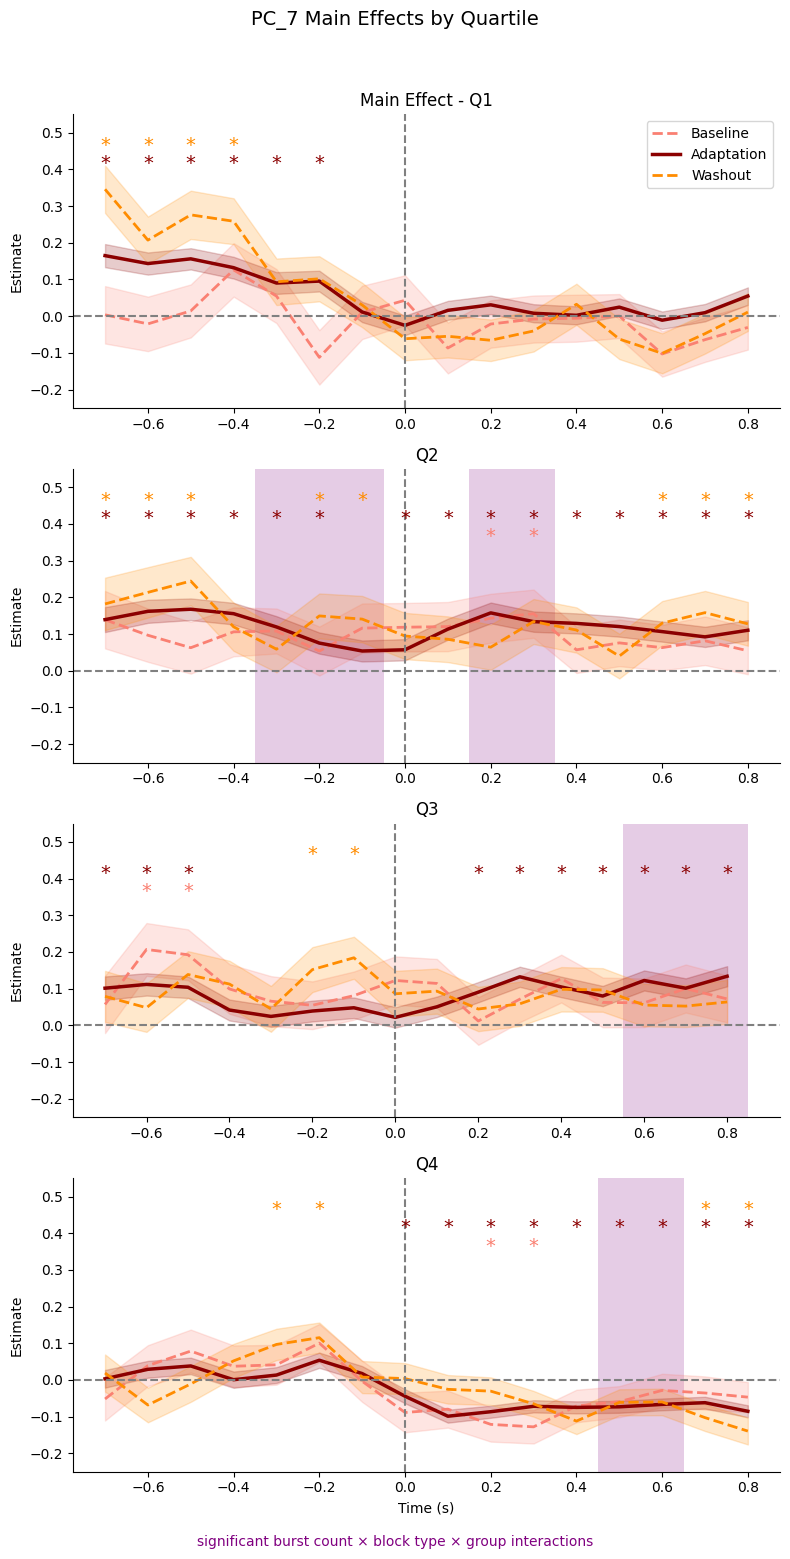

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define color palettes
adapt1 = sns.color_palette("Set1", n_colors=9)
colors1 = sns.color_palette("mako_r", n_colors=10)
colorbl = [adapt1[4], colors1[2]]

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Initialize variables for time windows
start, end, step = -0.8, 0.8, 0.1
start_2, end_2 = -0.6, 1
window_start = np.arange(start, end, step)
window_end = np.arange(start_2, end_2, step)

# Prepare figure for 4x1 grid of plots (single column)
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 16)
)
fig.subplots_adjust(hspace=0.3)

# Define block colors
block_colors = ['salmon', 'darkred', 'darkorange']  # salmon for baseline, darkred for adaptation, darkorange for washout

# Loop through each quartile
col_r = plt.cm.cool(np.linspace(0, 1, num=4))
for q in range(4):
    # Dictionaries to store data for each block type - only main effects
    block_data = {block_name: {"main_effect": []} for block_name in block_types.keys()}
    
    # For each quartile, create a dictionary to store combined data across block types for each time window
    combined_window_data = {}
    
    # Process data for each block type and time window
    for block_name, block_num in block_types.items():
        for i in range(len(window_start)):
            current_window_start = window_start[i]
            current_window_end = window_end[i]
            current_window_mid = current_window_start + 0.5 * (current_window_end - current_window_start)

            # Format window values for file naming
            formatted_start = f"{current_window_start:.3f}".rstrip('0').rstrip('.')
            formatted_end = f"{current_window_end:.3f}".rstrip('0').rstrip('.')
            if formatted_start == '-0': formatted_start = '0'
            if formatted_end == '-0': formatted_end = '0'

            # File path for the current quartile and time window
            file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

            try:
                # Load data
                data = pd.read_csv(file_path)
                
                # Handle different block type conditions
                if block_name == "Adaptation":
                    data = data[data['block'].isin(block_num)]
                else:
                    data = data[data['block'] == block_num]
                
                data['log_rt'] = np.log10(data['reach_rt'])
                data['block_type'] = block_name
                
                data = data.reset_index(drop=True)
                data["subject"] = data["subject"].astype("category")
                data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])

                # ---------- MAIN EFFECT MODEL ----------
                model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count",
                    data,
                    groups=data["subject"]
                )
                model_fit = model.fit()

                # Extract results for main effect
                coef = model_fit.params
                stderr = model_fit.bse

                # Store main effect results
                block_data[block_name]["main_effect"].append({
                    "window": current_window_mid,
                    "Estimate": coef.get("burst_count", np.nan),
                    "SE": stderr.get("burst_count", np.nan),
                    "p_value": model_fit.pvalues.get("burst_count", np.nan),
                })

                # ---------- TRIPLE INTERACTION DATA COLLECTION ----------
                # Store data for combined model (across block types)
                window_key = f"{formatted_start}_{formatted_end}"
                if window_key not in combined_window_data:
                    combined_window_data[window_key] = {
                        "data": [],
                        "window_mid": current_window_mid
                    }
                
                # Add this block's data to the combined dataset
                combined_window_data[window_key]["data"].append(data)

            except FileNotFoundError:
                pass
    
    # Run the triple interaction models on the combined data for each time window
    triple_interaction_results = []
    
    for window_key, window_info in combined_window_data.items():
        if len(window_info["data"]) > 1:  # Need at least 2 block types to test interaction
            # Combine data from all available block types for this time window
            combined_data = pd.concat(window_info["data"], ignore_index=True)
            
            try:
                # Check that we have at least two groups in the data
                if len(combined_data['group'].unique()) < 2:
                    continue
                
                # Ensure 'group' is properly treated as categorical
                combined_data['group'] = combined_data['group'].astype('category')
                
                # Fit model with triple interaction (burst_count × block_type × group)
                triple_interaction_model = smf.mixedlm(
                    "reach_vis_abs_err ~ burst_count * block_type * group",
                    combined_data,
                    groups=combined_data["subject"]
                )
                triple_interaction_fit = triple_interaction_model.fit()
                
                # Extract the triple interaction terms - looking for terms with all three variables
                triple_interaction_terms = [term for term in triple_interaction_fit.pvalues.index 
                                          if "burst_count" in term and "block_type" in term and "group" in term and "burst_count" in term]
                
                # Get p-values for triple interaction terms
                if triple_interaction_terms:
                    min_p_value = min([triple_interaction_fit.pvalues[term] for term in triple_interaction_terms])
                else:
                    min_p_value = np.nan
                
                # Store results
                triple_interaction_results.append({
                    "window_mid": window_info["window_mid"],
                    "p_value": min_p_value
                })
                    
            except Exception as e:
                pass
    
    # Convert to DataFrames for main effects
    for block_name in block_types.keys():
        block_data[block_name]["main_effect_df"] = pd.DataFrame(block_data[block_name]["main_effect"])
        # Sort by window time
        if not block_data[block_name]["main_effect_df"].empty:
            block_data[block_name]["main_effect_df"] = block_data[block_name]["main_effect_df"].sort_values("window")
    
    # Convert triple interaction results to DataFrame
    triple_interaction_df = pd.DataFrame([
        {"window": res["window_mid"], "p_value": res["p_value"]}
        for res in triple_interaction_results
    ])
    
    # Sort by window time
    if not triple_interaction_df.empty:
        triple_interaction_df = triple_interaction_df.sort_values("window")

    # Plot on the appropriate subplot position in the single column
    ax_main = axes[q]
    
    # Plot Main Effect with Triple Interaction highlights
    # Adaptation as solid line, baseline and washout as dashed
    line_styles = ['--', '-', '--']  # baseline dashed, adaptation solid, washout dashed
    line_widths = [2.0, 2.5, 2.0]
    
    # Plot main effects
    for idx, (block_name, block_info) in enumerate(block_data.items()):
        if not block_info["main_effect_df"].empty:
            # Plot the main effect lines
            ax_main.plot(
                block_info["main_effect_df"]["window"], 
                block_info["main_effect_df"]["Estimate"], 
                color=block_colors[idx], 
                linestyle=line_styles[idx],
                linewidth=line_widths[idx],
                label=f"{block_name}" if q == 0 else None
            )
            # Plot shaded error areas
            ax_main.fill_between(
                block_info["main_effect_df"]["window"],
                block_info["main_effect_df"]["Estimate"] - block_info["main_effect_df"]["SE"],
                block_info["main_effect_df"]["Estimate"] + block_info["main_effect_df"]["SE"],
                alpha=0.2,
                color=block_colors[idx]
            )
            
            # remove the top and right spines
            ax_main.spines['top'].set_visible(False)
            ax_main.spines['right'].set_visible(False)
            
            # Find consecutive significant time windows for main effects
            df = block_info["main_effect_df"]
            if not df.empty and len(df) > 1:
                # Initialize the significant windows list
                sig_windows = []
                
                # Create a list of window indices where p < 0.05
                sig_indices = df.index[df["p_value"] < 0.05].tolist()
                
                # Find consecutive runs
                if sig_indices:
                    # Start with the first significant index
                    current_run = [sig_indices[0]]
                    
                    # Go through the rest of the significant indices
                    for i in range(1, len(sig_indices)):
                        # If this index follows the previous one, extend the current run
                        if sig_indices[i] == sig_indices[i-1] + 1:
                            current_run.append(sig_indices[i])
                        else:
                            # If the run has 2 or more consecutive windows, store it
                            if len(current_run) >= 2:
                                sig_windows.append(current_run)
                            # Start a new run
                            current_run = [sig_indices[i]]
                    
                    # Don't forget to add the last run if it's valid
                    if len(current_run) >= 2:
                        sig_windows.append(current_run)
                
                # Add significance markers only for consecutive windows
                for run in sig_windows:
                    # Get the actual window values for these indices
                    run_windows = df.iloc[run]["window"].values
                    # Add star for each window in the run
                    for w in run_windows:
                        y_pos = 0.35 + (0.05 * idx)  # Offset to avoid overlap
                        ax_main.text(w, y_pos, "*", color=block_colors[idx], fontsize=14, ha='center')
    
    # Handle triple interaction effects - find consecutive significant windows
    if not triple_interaction_df.empty and len(triple_interaction_df) > 1:
        # Sort by window value to ensure correct order
        triple_interaction_df = triple_interaction_df.sort_values("window").reset_index(drop=True)
        
        triple_interaction_df["significant"] = triple_interaction_df["p_value"] < 0.05 / 4
        
        # Find runs of consecutive significant windows
        significant_runs = []
        in_run = False
        current_run = []
        
        for i, row in triple_interaction_df.iterrows():
            if row["significant"]:
                if not in_run:
                    # Start a new run
                    in_run = True
                    current_run = [row["window"]]
                else:
                    # Continue the current run
                    current_run.append(row["window"])
                    
                # Check if we're at the end
                if i == len(triple_interaction_df) - 1 and len(current_run) >= 2:
                    significant_runs.append(current_run)
            else:
                # End the current run if it has enough windows
                if in_run and len(current_run) >= 2:
                    significant_runs.append(current_run)
                in_run = False
                current_run = []
        
        # Add purple shaded areas only for runs of consecutive significant windows
        for run in significant_runs:
            # Shade from the start of the first window to the end of the last window
            ax_main.axvspan(
                min(run) - 0.05,  # Start slightly before
                max(run) + 0.05,  # End slightly after
                alpha=0.2,
                color='purple',
                zorder=0,
                linewidth=0,
                edgecolor='none'
            )
    
    ax_main.axvline(0, linestyle="--", color="grey")
    ax_main.axhline(0, linestyle="--", color="grey")
    ax_main.set_title(f"Main Effect - Q{q+1}" if q == 0 else f"Q{q+1}")
    ax_main.set_ylim(-0.25, 0.55)
    
    # Add x-axis labels only to the bottom subplot
    if q == 3:
        ax_main.set_xlabel("Time (s)")
    
    # Add y-axis label to all subplots
    ax_main.set_ylabel("Estimate")
    
    # Add legend to the first subplot only
    if q == 0:
        ax_main.legend(fontsize=10, loc="upper right")

# Add a note about the purple shaded areas (now with consecutive window requirement)
fig.text(0.5, 0.02, "significant burst count × block type × group interactions", 
         ha='center', fontsize=10, color='purple')

# Add a common title for all subplots
plt.suptitle(f"{pc_key} Main Effects by Quartile", fontsize=14, y=0.98)

# Display all plots
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Running analysis for Q2, window -0.3 to -0.1
Number of observations: 15693
Groups: ['Explicit' 'Implicit']
Block types: ['Baseline' 'Adaptation' 'Washout']

========== FULL MODEL SUMMARY ==========
                                Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             reach_vis_abs_err
No. Observations:               15693               Method:                         REML             
No. Groups:                     37                  Scale:                          261.2978         
Min. group size:                403                 Log-Likelihood:                 -65973.7441      
Max. group size:                439                 Converged:                      Yes              
Mean group size:                424.1                                                                
-----------------------------------------------------------------------------------------------------
                  

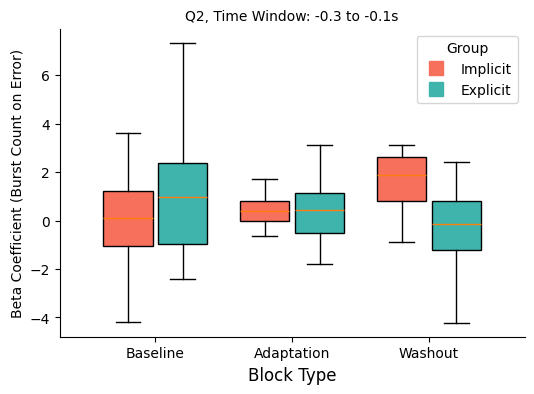

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Define the specific quartile and time window we want to analyze
q = 1  # Q2
target_window_start = -0.3
target_window_end = -0.1

# Format window values for file naming
formatted_start = f"{target_window_start:.3f}".rstrip('0').rstrip('.')
formatted_end = f"{target_window_end:.3f}".rstrip('0').rstrip('.')
if formatted_start == '-0': formatted_start = '0'
if formatted_end == '-0': formatted_end = '0'

# Dictionary to store data from all block types
combined_data_list = []

# Process data for each block type
for block_name, block_num in block_types.items():
    # File path for the target quartile and time window
    file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

    # Load data
    data = pd.read_csv(file_path)
    
    # Handle different block type conditions
    if block_name == "Adaptation":
        data = data[data['block'].isin(block_num)]
    else:
        data = data[data['block'] == block_num]
    
    data['log_rt'] = np.log10(data['reach_rt'])
    data['block_type'] = block_name
    
    data = data.reset_index(drop=True)
    data["subject"] = data["subject"].astype("category")
    data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])
    
    # Add this block's data to the combined dataset
    combined_data_list.append(data)

# Combine data from all block types
combined_data = pd.concat(combined_data_list, ignore_index=True)

# Ensure categorical variables are properly encoded, but without ordering
combined_data['group'] = combined_data['group'].astype(str)  # Convert to string first
combined_data['block_type'] = combined_data['block_type'].astype(str)

# Standardize burst_count for consistent interpretation
scaler = StandardScaler()
combined_data['burst_count_std'] = scaler.fit_transform(combined_data[['burst_count']])

# Print data summary
print(f"Running analysis for Q{q+1}, window {target_window_start} to {target_window_end}")
print(f"Number of observations: {len(combined_data)}")
print(f"Groups: {combined_data['group'].unique()}")
print(f"Block types: {combined_data['block_type'].unique()}")

# Get unique combinations of group and block type
group_values = combined_data['group'].unique()
block_type_values = combined_data['block_type'].unique()

# Create dataframe to store beta coefficients
beta_results = []

# 1. Fit the full interaction model
full_model = smf.mixedlm(
    "reach_vis_abs_err ~ burst_count_std * block_type * group",
    combined_data,
    groups=combined_data["subject"]
)
full_model_fit = full_model.fit()

print("\n========== FULL MODEL SUMMARY ==========")
print(full_model_fit.summary())

# 2. For each group and block type combination, calculate subject-specific beta coefficients
subject_beta_results = []
n_bootstraps = 50  # Number of bootstraps for visualization

for group in group_values:
    for block_type in block_type_values:
        # Filter data for this combination
        subset = combined_data[
            (combined_data['group'] == group) & 
            (combined_data['block_type'] == block_type)
        ]
        
        # Get unique subjects in this subset
        subjects = subset['subject'].unique()
        
        # Calculate per-subject beta coefficients
        for subject in subjects:
            subject_data = subset[subset['subject'] == subject]
            
            # Simple regression for this subject
            X = subject_data['burst_count_std'].values.reshape(-1, 1)
            y = subject_data['reach_vis_abs_err'].values
            
            # Fit model for this subject
            model = LinearRegression()
            model.fit(X, y)
            
            # Store the coefficient
            subject_beta_results.append({
                'Group': group,
                'Block_Type': block_type,
                'Subject': subject,
                'Beta_Coefficient': model.coef_[0]
            })
        
        # Fit a separate model for the overall effect
        subset_model = smf.mixedlm(
            "reach_vis_abs_err ~ burst_count_std",
            subset,
            groups=subset["subject"]
        )
        subset_model_fit = subset_model.fit()
        
        # Extract the coefficient and statistics
        coef = subset_model_fit.params['burst_count_std']
        stderr = subset_model_fit.bse['burst_count_std']
        tvalue = subset_model_fit.tvalues['burst_count_std'] 
        pvalue = subset_model_fit.pvalues['burst_count_std']
        
        # Store results
        beta_results.append({
            'Group': group,
            'Block_Type': block_type,
            'Beta_Coefficient': coef,
            'Std_Error': stderr,
            'T_Value': tvalue,
            'P_Value': pvalue,
            'Significant': pvalue < 0.05,
            'Sample_Size': len(subset)
        })

# 3. Convert to DataFrame and sort for easy interpretation
beta_df = pd.DataFrame(beta_results)
subject_beta_df = pd.DataFrame(subject_beta_results)

# Use list format for output - sort by Block_Type
beta_df = beta_df.sort_values(['Block_Type'])

# 4. Save the beta coefficients to a CSV file
output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_beta_coefficients.csv"
beta_df.to_csv(output_file, index=False)
print(f"\nBeta coefficients saved to {output_file}")

# Also save the subject-specific betas
subject_output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_subject_betas.csv"
subject_beta_df.to_csv(subject_output_file, index=False)
print(f"Subject-specific beta coefficients saved to {subject_output_file}")

# 5. Print a summary table of the beta coefficients
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n========== BETA COEFFICIENTS BY GROUP AND BLOCK TYPE ==========")
print(beta_df[['Group', 'Block_Type', 'Beta_Coefficient', 'P_Value', 'Significant', 'Sample_Size']])

# 6. Calculate the differences between groups for each block type
print("\n========== COMPARISONS FROM FULL MODEL ==========")
print("Computing differences between groups and block types from the full interaction model:")

# Extract main effect of burst count
main_effect = full_model_fit.params.get('burst_count_std', 0)
print(f"\nMain effect of burst_count_std: {main_effect:.4f}")

# Extract interaction terms
interaction_terms = {param: value for param, value in full_model_fit.params.items() 
                   if "burst_count_std" in param}

# Print all burst count related terms
print("\nAll burst count related coefficients:")
for term, value in interaction_terms.items():
    pvalue = full_model_fit.pvalues[term]
    print(f"{term}: {value:.4f} (p={pvalue:.4f})")

# 7. Calculate actual beta coefficients for each combination from the full model
print("\nDerived beta coefficients from full model for each combination:")

# Create reference variables (first group and first block type)
reference_group = list(group_values)[0]
reference_block = list(block_type_values)[0]

for group in group_values:
    for block_type in block_type_values:
        # Start with the main effect of burst count
        total_effect = main_effect
        
        # Add group effect if not reference group
        if group != reference_group:
            group_effect_term = f'burst_count_std:group[T.{group}]'
            if group_effect_term in interaction_terms:
                total_effect += interaction_terms[group_effect_term]
        
        # Add block type effect if not reference block
        if block_type != reference_block:
            block_effect_term = f'burst_count_std:block_type[T.{block_type}]'
            if block_effect_term in interaction_terms:
                total_effect += interaction_terms[block_effect_term]
        
        # Add interaction effect if neither is reference
        if group != reference_group and block_type != reference_block:
            interaction_effect_term = f'burst_count_std:block_type[T.{block_type}]:group[T.{group}]'
            if interaction_effect_term in interaction_terms:
                total_effect += interaction_terms[interaction_effect_term]
        
        print(f"{group}, {block_type}: {total_effect:.4f}")

# 8. Create boxplots to visualize the beta coefficients using matplotlib
plt.figure(figsize=(6, 4))

# Create a clean, plain white background
plt.rcParams['axes.facecolor'] = 'white'

# Create a new column combining group and block type for better visualization
subject_beta_df['Group_Block'] = subject_beta_df['Group'] + ', ' + subject_beta_df['Block_Type']

# Get unique block types and groups for plotting
unique_blocks = subject_beta_df['Block_Type'].unique()
unique_groups = subject_beta_df['Group'].unique()

# Make sure 'Implicit' comes first in the group order
if 'Implicit' in unique_groups and 'Explicit' in unique_groups:
    unique_groups = np.array(['Implicit', 'Explicit'])

# Import colormaps for custom colors
from matplotlib.cm import get_cmap

# Get color maps for the different groups
magma_r_cmap = get_cmap('magma_r')
mako_r_cmap = get_cmap('mako_r')

# Calculate positions for each box
positions = []
width = 0.8 / len(unique_groups)
for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)

# Create boxplots manually using matplotlib
box_stats = []
box_positions = []
box_colors = []

for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        data = subject_beta_df[(subject_beta_df['Block_Type'] == block) & 
                              (subject_beta_df['Group'] == group)]['Beta_Coefficient']
        
        if len(data) > 0:
            box_positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)
            
            # Assign colors based on group
            if group == 'Implicit':
                box_colors.append(magma_r_cmap(0.3))  # magma_r for Implicit
            elif group == 'Explicit':
                box_colors.append(mako_r_cmap(0.3))   # mako_r for Explicit
            else:
                # Fallback for any other groups
                box_colors.append(plt.cm.tab10(j % 10))
                
            box_stats.append(data)

# Create the boxplots
bp = plt.boxplot(box_stats, positions=box_positions, widths=width*0.9, patch_artist=True,
                 showfliers=False)

# Color the boxes
for box, color in zip(bp['boxes'], box_colors):
    box.set(facecolor=color)
    box.set(edgecolor='black')

# Customize the plot appearance
plt.xlabel('Block Type', fontsize=12)
plt.ylabel('Beta Coefficient (Burst Count on Error)', fontsize=10)
plt.title(f'Q{q+1}, Time Window: {target_window_start} to {target_window_end}s', fontsize=10)
plt.grid(False)

# Set the x-ticks and labels
plt.xticks(range(len(unique_blocks)), unique_blocks)

# Create a custom legend
legend_elements = []
for i, group in enumerate(unique_groups):
    if group == 'Implicit':
        color = magma_r_cmap(0.3)
    elif group == 'Explicit':
        color = mako_r_cmap(0.3)
    else:
        color = plt.cm.tab10(i % 10)
        
    legend_elements.append(plt.Line2D([0], [0], color=color, 
                          marker='s', markersize=10, linestyle='None', label=group))
plt.legend(handles=legend_elements, title='Group', loc='best')

# Set axis limits and spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


Running analysis for Q2, window 0.1 to 0.3
Number of observations: 15607
Groups: ['Explicit' 'Implicit']
Block types: ['Baseline' 'Adaptation' 'Washout']

========== FULL MODEL SUMMARY ==========
                                Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             reach_vis_abs_err
No. Observations:               15607               Method:                         REML             
No. Groups:                     37                  Scale:                          261.9240         
Min. group size:                395                 Log-Likelihood:                 -65631.9202      
Max. group size:                439                 Converged:                      Yes              
Mean group size:                421.8                                                                
-----------------------------------------------------------------------------------------------------
                    

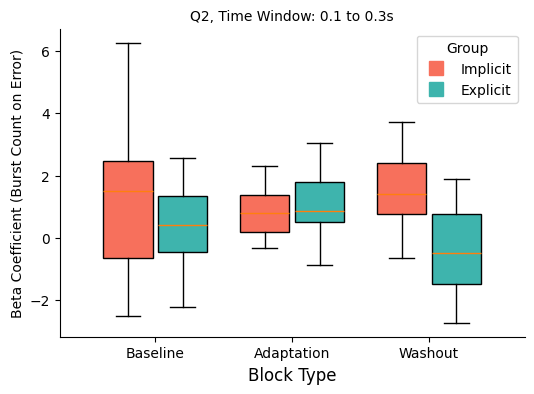

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Define the specific quartile and time window we want to analyze
q = 1  # Q2
target_window_start = 0.1
target_window_end = 0.3

# Format window values for file naming
formatted_start = f"{target_window_start:.3f}".rstrip('0').rstrip('.')
formatted_end = f"{target_window_end:.3f}".rstrip('0').rstrip('.')
if formatted_start == '-0': formatted_start = '0'
if formatted_end == '-0': formatted_end = '0'

# Dictionary to store data from all block types
combined_data_list = []

# Process data for each block type
for block_name, block_num in block_types.items():
    # File path for the target quartile and time window
    file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

    # Load data
    data = pd.read_csv(file_path)
    
    # Handle different block type conditions
    if block_name == "Adaptation":
        data = data[data['block'].isin(block_num)]
    else:
        data = data[data['block'] == block_num]
    
    data['log_rt'] = np.log10(data['reach_rt'])
    data['block_type'] = block_name
    
    data = data.reset_index(drop=True)
    data["subject"] = data["subject"].astype("category")
    data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])
    
    # Add this block's data to the combined dataset
    combined_data_list.append(data)

# Combine data from all block types
combined_data = pd.concat(combined_data_list, ignore_index=True)

# Ensure categorical variables are properly encoded, but without ordering
combined_data['group'] = combined_data['group'].astype(str)  # Convert to string first
combined_data['block_type'] = combined_data['block_type'].astype(str)

# Standardize burst_count for consistent interpretation
scaler = StandardScaler()
combined_data['burst_count_std'] = scaler.fit_transform(combined_data[['burst_count']])

# Print data summary
print(f"Running analysis for Q{q+1}, window {target_window_start} to {target_window_end}")
print(f"Number of observations: {len(combined_data)}")
print(f"Groups: {combined_data['group'].unique()}")
print(f"Block types: {combined_data['block_type'].unique()}")

# Get unique combinations of group and block type
group_values = combined_data['group'].unique()
block_type_values = combined_data['block_type'].unique()

# Create dataframe to store beta coefficients
beta_results = []

# 1. Fit the full interaction model
full_model = smf.mixedlm(
    "reach_vis_abs_err ~ burst_count_std * block_type * group",
    combined_data,
    groups=combined_data["subject"]
)
full_model_fit = full_model.fit()

print("\n========== FULL MODEL SUMMARY ==========")
print(full_model_fit.summary())

# 2. For each group and block type combination, calculate subject-specific beta coefficients
subject_beta_results = []
n_bootstraps = 50  # Number of bootstraps for visualization

for group in group_values:
    for block_type in block_type_values:
        # Filter data for this combination
        subset = combined_data[
            (combined_data['group'] == group) & 
            (combined_data['block_type'] == block_type)
        ]
        
        # Get unique subjects in this subset
        subjects = subset['subject'].unique()
        
        # Calculate per-subject beta coefficients
        for subject in subjects:
            subject_data = subset[subset['subject'] == subject]
            
            # Simple regression for this subject
            X = subject_data['burst_count_std'].values.reshape(-1, 1)
            y = subject_data['reach_vis_abs_err'].values
            
            # Fit model for this subject
            model = LinearRegression()
            model.fit(X, y)
            
            # Store the coefficient
            subject_beta_results.append({
                'Group': group,
                'Block_Type': block_type,
                'Subject': subject,
                'Beta_Coefficient': model.coef_[0]
            })
        
        # Fit a separate model for the overall effect
        subset_model = smf.mixedlm(
            "reach_vis_abs_err ~ burst_count_std",
            subset,
            groups=subset["subject"]
        )
        subset_model_fit = subset_model.fit()
        
        # Extract the coefficient and statistics
        coef = subset_model_fit.params['burst_count_std']
        stderr = subset_model_fit.bse['burst_count_std']
        tvalue = subset_model_fit.tvalues['burst_count_std'] 
        pvalue = subset_model_fit.pvalues['burst_count_std']
        
        # Store results
        beta_results.append({
            'Group': group,
            'Block_Type': block_type,
            'Beta_Coefficient': coef,
            'Std_Error': stderr,
            'T_Value': tvalue,
            'P_Value': pvalue,
            'Significant': pvalue < 0.05,
            'Sample_Size': len(subset)
        })

# 3. Convert to DataFrame and sort for easy interpretation
beta_df = pd.DataFrame(beta_results)
subject_beta_df = pd.DataFrame(subject_beta_results)

# Use list format for output - sort by Block_Type
beta_df = beta_df.sort_values(['Block_Type'])

# 4. Save the beta coefficients to a CSV file
output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_beta_coefficients.csv"
beta_df.to_csv(output_file, index=False)
print(f"\nBeta coefficients saved to {output_file}")

# Also save the subject-specific betas
subject_output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_subject_betas.csv"
subject_beta_df.to_csv(subject_output_file, index=False)
print(f"Subject-specific beta coefficients saved to {subject_output_file}")

# 5. Print a summary table of the beta coefficients
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n========== BETA COEFFICIENTS BY GROUP AND BLOCK TYPE ==========")
print(beta_df[['Group', 'Block_Type', 'Beta_Coefficient', 'P_Value', 'Significant', 'Sample_Size']])

# 6. Calculate the differences between groups for each block type
print("\n========== COMPARISONS FROM FULL MODEL ==========")
print("Computing differences between groups and block types from the full interaction model:")

# Extract main effect of burst count
main_effect = full_model_fit.params.get('burst_count_std', 0)
print(f"\nMain effect of burst_count_std: {main_effect:.4f}")

# Extract interaction terms
interaction_terms = {param: value for param, value in full_model_fit.params.items() 
                   if "burst_count_std" in param}

# Print all burst count related terms
print("\nAll burst count related coefficients:")
for term, value in interaction_terms.items():
    pvalue = full_model_fit.pvalues[term]
    print(f"{term}: {value:.4f} (p={pvalue:.4f})")

# 7. Calculate actual beta coefficients for each combination from the full model
print("\nDerived beta coefficients from full model for each combination:")

# Create reference variables (first group and first block type)
reference_group = list(group_values)[0]
reference_block = list(block_type_values)[0]

for group in group_values:
    for block_type in block_type_values:
        # Start with the main effect of burst count
        total_effect = main_effect
        
        # Add group effect if not reference group
        if group != reference_group:
            group_effect_term = f'burst_count_std:group[T.{group}]'
            if group_effect_term in interaction_terms:
                total_effect += interaction_terms[group_effect_term]
        
        # Add block type effect if not reference block
        if block_type != reference_block:
            block_effect_term = f'burst_count_std:block_type[T.{block_type}]'
            if block_effect_term in interaction_terms:
                total_effect += interaction_terms[block_effect_term]
        
        # Add interaction effect if neither is reference
        if group != reference_group and block_type != reference_block:
            interaction_effect_term = f'burst_count_std:block_type[T.{block_type}]:group[T.{group}]'
            if interaction_effect_term in interaction_terms:
                total_effect += interaction_terms[interaction_effect_term]
        
        print(f"{group}, {block_type}: {total_effect:.4f}")

# 8. Create boxplots to visualize the beta coefficients using matplotlib
plt.figure(figsize=(6, 4))

# Create a clean, plain white background
plt.rcParams['axes.facecolor'] = 'white'

# Create a new column combining group and block type for better visualization
subject_beta_df['Group_Block'] = subject_beta_df['Group'] + ', ' + subject_beta_df['Block_Type']

# Get unique block types and groups for plotting
unique_blocks = subject_beta_df['Block_Type'].unique()
unique_groups = subject_beta_df['Group'].unique()

# Make sure 'Implicit' comes first in the group order
if 'Implicit' in unique_groups and 'Explicit' in unique_groups:
    unique_groups = np.array(['Implicit', 'Explicit'])

# Import colormaps for custom colors
from matplotlib.cm import get_cmap

# Get color maps for the different groups
magma_r_cmap = get_cmap('magma_r')
mako_r_cmap = get_cmap('mako_r')

# Calculate positions for each box
positions = []
width = 0.8 / len(unique_groups)
for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)

# Create boxplots manually using matplotlib
box_stats = []
box_positions = []
box_colors = []

for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        data = subject_beta_df[(subject_beta_df['Block_Type'] == block) & 
                              (subject_beta_df['Group'] == group)]['Beta_Coefficient']
        
        if len(data) > 0:
            box_positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)
            
            # Assign colors based on group
            if group == 'Implicit':
                box_colors.append(magma_r_cmap(0.3))  # magma_r for Implicit
            elif group == 'Explicit':
                box_colors.append(mako_r_cmap(0.3))   # mako_r for Explicit
            else:
                # Fallback for any other groups
                box_colors.append(plt.cm.tab10(j % 10))
                
            box_stats.append(data)

# Create the boxplots
bp = plt.boxplot(box_stats, positions=box_positions, widths=width*0.9, patch_artist=True,
                 showfliers=False)

# Color the boxes
for box, color in zip(bp['boxes'], box_colors):
    box.set(facecolor=color)
    box.set(edgecolor='black')

# Customize the plot appearance
plt.xlabel('Block Type', fontsize=12)
plt.ylabel('Beta Coefficient (Burst Count on Error)', fontsize=10)
plt.title(f'Q{q+1}, Time Window: {target_window_start} to {target_window_end}s', fontsize=10)
plt.grid(False)

# Set the x-ticks and labels
plt.xticks(range(len(unique_blocks)), unique_blocks)

# Create a custom legend
legend_elements = []
for i, group in enumerate(unique_groups):
    if group == 'Implicit':
        color = magma_r_cmap(0.3)
    elif group == 'Explicit':
        color = mako_r_cmap(0.3)
    else:
        color = plt.cm.tab10(i % 10)
        
    legend_elements.append(plt.Line2D([0], [0], color=color, 
                          marker='s', markersize=10, linestyle='None', label=group))
plt.legend(handles=legend_elements, title='Group', loc='best')

# Set axis limits and spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

Running analysis for Q3, window 0.5 to 0.7
Number of observations: 15725
Groups: ['Explicit' 'Implicit']
Block types: ['Baseline' 'Adaptation' 'Washout']

========== FULL MODEL SUMMARY ==========
                                Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             reach_vis_abs_err
No. Observations:               15725               Method:                         REML             
No. Groups:                     37                  Scale:                          261.7322         
Min. group size:                408                 Log-Likelihood:                 -66120.9315      
Max. group size:                439                 Converged:                      Yes              
Mean group size:                425.0                                                                
-----------------------------------------------------------------------------------------------------
                    

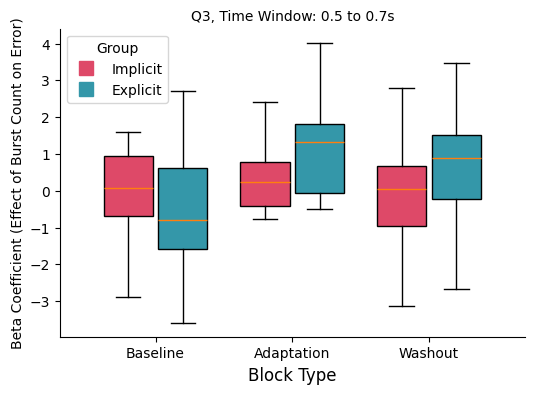

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Define the specific quartile and time window we want to analyze
q = 2  # Q2
target_window_start = 0.5
target_window_end = 0.7

# Format window values for file naming
formatted_start = f"{target_window_start:.3f}".rstrip('0').rstrip('.')
formatted_end = f"{target_window_end:.3f}".rstrip('0').rstrip('.')
if formatted_start == '-0': formatted_start = '0'
if formatted_end == '-0': formatted_end = '0'

# Dictionary to store data from all block types
combined_data_list = []

# Process data for each block type
for block_name, block_num in block_types.items():
    # File path for the target quartile and time window
    file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

    # Load data
    data = pd.read_csv(file_path)
    
    # Handle different block type conditions
    if block_name == "Adaptation":
        data = data[data['block'].isin(block_num)]
    else:
        data = data[data['block'] == block_num]
    
    data['log_rt'] = np.log10(data['reach_rt'])
    data['block_type'] = block_name
    
    data = data.reset_index(drop=True)
    data["subject"] = data["subject"].astype("category")
    data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])
    
    # Add this block's data to the combined dataset
    combined_data_list.append(data)

# Combine data from all block types
combined_data = pd.concat(combined_data_list, ignore_index=True)

# Ensure categorical variables are properly encoded, but without ordering
combined_data['group'] = combined_data['group'].astype(str)  # Convert to string first
combined_data['block_type'] = combined_data['block_type'].astype(str)

# Standardize burst_count for consistent interpretation
scaler = StandardScaler()
combined_data['burst_count_std'] = scaler.fit_transform(combined_data[['burst_count']])

# Print data summary
print(f"Running analysis for Q{q+1}, window {target_window_start} to {target_window_end}")
print(f"Number of observations: {len(combined_data)}")
print(f"Groups: {combined_data['group'].unique()}")
print(f"Block types: {combined_data['block_type'].unique()}")

# Get unique combinations of group and block type
group_values = combined_data['group'].unique()
block_type_values = combined_data['block_type'].unique()

# Create dataframe to store beta coefficients
beta_results = []

# 1. Fit the full interaction model
full_model = smf.mixedlm(
    "reach_vis_abs_err ~ burst_count_std * block_type * group",
    combined_data,
    groups=combined_data["subject"]
)
full_model_fit = full_model.fit()

print("\n========== FULL MODEL SUMMARY ==========")
print(full_model_fit.summary())

# 2. For each group and block type combination, calculate subject-specific beta coefficients
subject_beta_results = []
n_bootstraps = 50  # Number of bootstraps for visualization

for group in group_values:
    for block_type in block_type_values:
        # Filter data for this combination
        subset = combined_data[
            (combined_data['group'] == group) & 
            (combined_data['block_type'] == block_type)
        ]
        
        # Get unique subjects in this subset
        subjects = subset['subject'].unique()
        
        # Calculate per-subject beta coefficients
        for subject in subjects:
            subject_data = subset[subset['subject'] == subject]
            
            # Simple regression for this subject
            X = subject_data['burst_count_std'].values.reshape(-1, 1)
            y = subject_data['reach_vis_abs_err'].values
            
            # Fit model for this subject
            model = LinearRegression()
            model.fit(X, y)
            
            # Store the coefficient
            subject_beta_results.append({
                'Group': group,
                'Block_Type': block_type,
                'Subject': subject,
                'Beta_Coefficient': model.coef_[0]
            })
        
        # Fit a separate model for the overall effect
        subset_model = smf.mixedlm(
            "reach_vis_abs_err ~ burst_count_std",
            subset,
            groups=subset["subject"]
        )
        subset_model_fit = subset_model.fit()
        
        # Extract the coefficient and statistics
        coef = subset_model_fit.params['burst_count_std']
        stderr = subset_model_fit.bse['burst_count_std']
        tvalue = subset_model_fit.tvalues['burst_count_std'] 
        pvalue = subset_model_fit.pvalues['burst_count_std']
        
        # Store results
        beta_results.append({
            'Group': group,
            'Block_Type': block_type,
            'Beta_Coefficient': coef,
            'Std_Error': stderr,
            'T_Value': tvalue,
            'P_Value': pvalue,
            'Significant': pvalue < 0.05,
            'Sample_Size': len(subset)
        })

# 3. Convert to DataFrame and sort for easy interpretation
beta_df = pd.DataFrame(beta_results)
subject_beta_df = pd.DataFrame(subject_beta_results)

# Use list format for output - sort by Block_Type
beta_df = beta_df.sort_values(['Block_Type'])

# 4. Save the beta coefficients to a CSV file
output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_beta_coefficients.csv"
beta_df.to_csv(output_file, index=False)
print(f"\nBeta coefficients saved to {output_file}")

# Also save the subject-specific betas
subject_output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_subject_betas.csv"
subject_beta_df.to_csv(subject_output_file, index=False)
print(f"Subject-specific beta coefficients saved to {subject_output_file}")

# 5. Print a summary table of the beta coefficients
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n========== BETA COEFFICIENTS BY GROUP AND BLOCK TYPE ==========")
print(beta_df[['Group', 'Block_Type', 'Beta_Coefficient', 'P_Value', 'Significant', 'Sample_Size']])

# 6. Calculate the differences between groups for each block type
print("\n========== COMPARISONS FROM FULL MODEL ==========")
print("Computing differences between groups and block types from the full interaction model:")

# Extract main effect of burst count
main_effect = full_model_fit.params.get('burst_count_std', 0)
print(f"\nMain effect of burst_count_std: {main_effect:.4f}")

# Extract interaction terms
interaction_terms = {param: value for param, value in full_model_fit.params.items() 
                   if "burst_count_std" in param}

# Print all burst count related terms
print("\nAll burst count related coefficients:")
for term, value in interaction_terms.items():
    pvalue = full_model_fit.pvalues[term]
    print(f"{term}: {value:.4f} (p={pvalue:.4f})")

# 7. Calculate actual beta coefficients for each combination from the full model
print("\nDerived beta coefficients from full model for each combination:")

# Create reference variables (first group and first block type)
reference_group = list(group_values)[0]
reference_block = list(block_type_values)[0]

for group in group_values:
    for block_type in block_type_values:
        # Start with the main effect of burst count
        total_effect = main_effect
        
        # Add group effect if not reference group
        if group != reference_group:
            group_effect_term = f'burst_count_std:group[T.{group}]'
            if group_effect_term in interaction_terms:
                total_effect += interaction_terms[group_effect_term]
        
        # Add block type effect if not reference block
        if block_type != reference_block:
            block_effect_term = f'burst_count_std:block_type[T.{block_type}]'
            if block_effect_term in interaction_terms:
                total_effect += interaction_terms[block_effect_term]
        
        # Add interaction effect if neither is reference
        if group != reference_group and block_type != reference_block:
            interaction_effect_term = f'burst_count_std:block_type[T.{block_type}]:group[T.{group}]'
            if interaction_effect_term in interaction_terms:
                total_effect += interaction_terms[interaction_effect_term]
        
        print(f"{group}, {block_type}: {total_effect:.4f}")

# 8. Create boxplots to visualize the beta coefficients using matplotlib
plt.figure(figsize=(6, 4))

# Create a clean, plain white background
plt.rcParams['axes.facecolor'] = 'white'

# Create a new column combining group and block type for better visualization
subject_beta_df['Group_Block'] = subject_beta_df['Group'] + ', ' + subject_beta_df['Block_Type']

# Get unique block types and groups for plotting
unique_blocks = subject_beta_df['Block_Type'].unique()
unique_groups = subject_beta_df['Group'].unique()

# Make sure 'Implicit' comes first in the group order
if 'Implicit' in unique_groups and 'Explicit' in unique_groups:
    unique_groups = np.array(['Implicit', 'Explicit'])

# Import colormaps for custom colors
from matplotlib.cm import get_cmap

# Get color maps for the different groups
magma_r_cmap = get_cmap('magma_r')
mako_r_cmap = get_cmap('mako_r')

# Calculate positions for each box
positions = []
width = 0.8 / len(unique_groups)
for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)

# Create boxplots manually using matplotlib
box_stats = []
box_positions = []
box_colors = []

for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        data = subject_beta_df[(subject_beta_df['Block_Type'] == block) & 
                              (subject_beta_df['Group'] == group)]['Beta_Coefficient']
        
        if len(data) > 0:
            box_positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)
            
            # Assign colors based on group
            if group == 'Implicit':
                box_colors.append(magma_r_cmap(0.4))  # magma_r for Implicit
            elif group == 'Explicit':
                box_colors.append(mako_r_cmap(0.4))   # mako_r for Explicit
            else:
                # Fallback for any other groups
                box_colors.append(plt.cm.tab10(j % 10))
                
            box_stats.append(data)

# Create the boxplots
bp = plt.boxplot(box_stats, positions=box_positions, widths=width*0.9, patch_artist=True,
                 showfliers=False)

# Color the boxes
for box, color in zip(bp['boxes'], box_colors):
    box.set(facecolor=color)
    box.set(edgecolor='black')

# Customize the plot appearance
plt.xlabel('Block Type', fontsize=12)
plt.ylabel('Beta Coefficient (Effect of Burst Count on Error)', fontsize=10)
plt.title(f'Q{q+1}, Time Window: {target_window_start} to {target_window_end}s', fontsize=10)
plt.grid(False)

# Set the x-ticks and labels
plt.xticks(range(len(unique_blocks)), unique_blocks)

# Create a custom legend
legend_elements = []
for i, group in enumerate(unique_groups):
    if group == 'Implicit':
        color = magma_r_cmap(0.4)
    elif group == 'Explicit':
        color = mako_r_cmap(0.4)
    else:
        color = plt.cm.tab10(i % 10)
        
    legend_elements.append(plt.Line2D([0], [0], color=color, 
                          marker='s', markersize=10, linestyle='None', label=group))
plt.legend(handles=legend_elements, title='Group', loc='best')

# Set axis limits and spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

Running analysis for Q4, window 0.4 to 0.6
Number of observations: 14554
Groups: ['Explicit' 'Implicit']
Block types: ['Baseline' 'Adaptation' 'Washout']

========== FULL MODEL SUMMARY ==========
                                Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             reach_vis_abs_err
No. Observations:               14554               Method:                         REML             
No. Groups:                     37                  Scale:                          259.7617         
Min. group size:                315                 Log-Likelihood:                 -61141.9983      
Max. group size:                437                 Converged:                      Yes              
Mean group size:                393.4                                                                
-----------------------------------------------------------------------------------------------------
                    

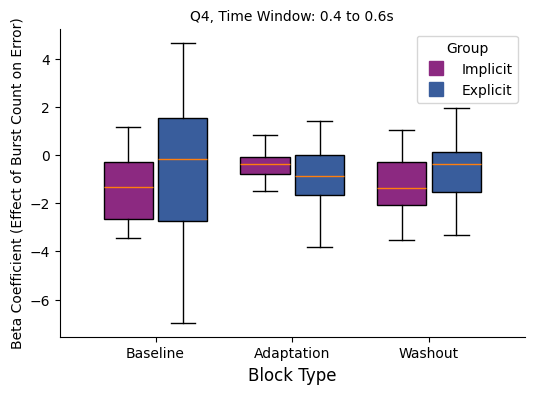

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# Define PC key
pc_key = "PC_7"

# Define block types and their corresponding numbers
block_types = {
    "Baseline": 0,
    "Adaptation": [1, 2, 3, 4, 5, 6],
    "Washout": 7
}

# Define the specific quartile and time window we want to analyze
q = 3  # Q2
target_window_start = 0.4
target_window_end = 0.6

# Format window values for file naming
formatted_start = f"{target_window_start:.3f}".rstrip('0').rstrip('.')
formatted_end = f"{target_window_end:.3f}".rstrip('0').rstrip('.')
if formatted_start == '-0': formatted_start = '0'
if formatted_end == '-0': formatted_end = '0'

# Dictionary to store data from all block types
combined_data_list = []

# Process data for each block type
for block_name, block_num in block_types.items():
    # File path for the target quartile and time window
    file_path = f'/home/qmoreau/Documents/Beta_bursts/Burst files/Motor_PCs_sliding_window/{pc_key}_Motor_SW/behav_df_Q{q}_window_{formatted_start}_{formatted_end}.csv'

    # Load data
    data = pd.read_csv(file_path)
    
    # Handle different block type conditions
    if block_name == "Adaptation":
        data = data[data['block'].isin(block_num)]
    else:
        data = data[data['block'] == block_num]
    
    data['log_rt'] = np.log10(data['reach_rt'])
    data['block_type'] = block_name
    
    data = data.reset_index(drop=True)
    data["subject"] = data["subject"].astype("category")
    data = data.dropna(subset=["reach_vis_abs_err", "burst_count", "group", "subject"])
    
    # Add this block's data to the combined dataset
    combined_data_list.append(data)

# Combine data from all block types
combined_data = pd.concat(combined_data_list, ignore_index=True)

# Ensure categorical variables are properly encoded, but without ordering
combined_data['group'] = combined_data['group'].astype(str)  # Convert to string first
combined_data['block_type'] = combined_data['block_type'].astype(str)

# Standardize burst_count for consistent interpretation
scaler = StandardScaler()
combined_data['burst_count_std'] = scaler.fit_transform(combined_data[['burst_count']])

# Print data summary
print(f"Running analysis for Q{q+1}, window {target_window_start} to {target_window_end}")
print(f"Number of observations: {len(combined_data)}")
print(f"Groups: {combined_data['group'].unique()}")
print(f"Block types: {combined_data['block_type'].unique()}")

# Get unique combinations of group and block type
group_values = combined_data['group'].unique()
block_type_values = combined_data['block_type'].unique()

# Create dataframe to store beta coefficients
beta_results = []

# 1. Fit the full interaction model
full_model = smf.mixedlm(
    "reach_vis_abs_err ~ burst_count_std * block_type * group",
    combined_data,
    groups=combined_data["subject"]
)
full_model_fit = full_model.fit()

print("\n========== FULL MODEL SUMMARY ==========")
print(full_model_fit.summary())

# 2. For each group and block type combination, calculate subject-specific beta coefficients
subject_beta_results = []
n_bootstraps = 50  # Number of bootstraps for visualization

for group in group_values:
    for block_type in block_type_values:
        # Filter data for this combination
        subset = combined_data[
            (combined_data['group'] == group) & 
            (combined_data['block_type'] == block_type)
        ]
        
        # Get unique subjects in this subset
        subjects = subset['subject'].unique()
        
        # Calculate per-subject beta coefficients
        for subject in subjects:
            subject_data = subset[subset['subject'] == subject]
            
            # Simple regression for this subject
            X = subject_data['burst_count_std'].values.reshape(-1, 1)
            y = subject_data['reach_vis_abs_err'].values
            
            # Fit model for this subject
            model = LinearRegression()
            model.fit(X, y)
            
            # Store the coefficient
            subject_beta_results.append({
                'Group': group,
                'Block_Type': block_type,
                'Subject': subject,
                'Beta_Coefficient': model.coef_[0]
            })
        
        # Fit a separate model for the overall effect
        subset_model = smf.mixedlm(
            "reach_vis_abs_err ~ burst_count_std",
            subset,
            groups=subset["subject"]
        )
        subset_model_fit = subset_model.fit()
        
        # Extract the coefficient and statistics
        coef = subset_model_fit.params['burst_count_std']
        stderr = subset_model_fit.bse['burst_count_std']
        tvalue = subset_model_fit.tvalues['burst_count_std'] 
        pvalue = subset_model_fit.pvalues['burst_count_std']
        
        # Store results
        beta_results.append({
            'Group': group,
            'Block_Type': block_type,
            'Beta_Coefficient': coef,
            'Std_Error': stderr,
            'T_Value': tvalue,
            'P_Value': pvalue,
            'Significant': pvalue < 0.05,
            'Sample_Size': len(subset)
        })

# 3. Convert to DataFrame and sort for easy interpretation
beta_df = pd.DataFrame(beta_results)
subject_beta_df = pd.DataFrame(subject_beta_results)

# Use list format for output - sort by Block_Type
beta_df = beta_df.sort_values(['Block_Type'])

# 4. Save the beta coefficients to a CSV file
output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_beta_coefficients.csv"
beta_df.to_csv(output_file, index=False)
print(f"\nBeta coefficients saved to {output_file}")

# Also save the subject-specific betas
subject_output_file = f"{pc_key}_Q{q+1}_window_{formatted_start}_{formatted_end}_subject_betas.csv"
subject_beta_df.to_csv(subject_output_file, index=False)
print(f"Subject-specific beta coefficients saved to {subject_output_file}")

# 5. Print a summary table of the beta coefficients
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n========== BETA COEFFICIENTS BY GROUP AND BLOCK TYPE ==========")
print(beta_df[['Group', 'Block_Type', 'Beta_Coefficient', 'P_Value', 'Significant', 'Sample_Size']])

# 6. Calculate the differences between groups for each block type
print("\n========== COMPARISONS FROM FULL MODEL ==========")
print("Computing differences between groups and block types from the full interaction model:")

# Extract main effect of burst count
main_effect = full_model_fit.params.get('burst_count_std', 0)
print(f"\nMain effect of burst_count_std: {main_effect:.4f}")

# Extract interaction terms
interaction_terms = {param: value for param, value in full_model_fit.params.items() 
                   if "burst_count_std" in param}

# Print all burst count related terms
print("\nAll burst count related coefficients:")
for term, value in interaction_terms.items():
    pvalue = full_model_fit.pvalues[term]
    print(f"{term}: {value:.4f} (p={pvalue:.4f})")

# 7. Calculate actual beta coefficients for each combination from the full model
print("\nDerived beta coefficients from full model for each combination:")

# Create reference variables (first group and first block type)
reference_group = list(group_values)[0]
reference_block = list(block_type_values)[0]

for group in group_values:
    for block_type in block_type_values:
        # Start with the main effect of burst count
        total_effect = main_effect
        
        # Add group effect if not reference group
        if group != reference_group:
            group_effect_term = f'burst_count_std:group[T.{group}]'
            if group_effect_term in interaction_terms:
                total_effect += interaction_terms[group_effect_term]
        
        # Add block type effect if not reference block
        if block_type != reference_block:
            block_effect_term = f'burst_count_std:block_type[T.{block_type}]'
            if block_effect_term in interaction_terms:
                total_effect += interaction_terms[block_effect_term]
        
        # Add interaction effect if neither is reference
        if group != reference_group and block_type != reference_block:
            interaction_effect_term = f'burst_count_std:block_type[T.{block_type}]:group[T.{group}]'
            if interaction_effect_term in interaction_terms:
                total_effect += interaction_terms[interaction_effect_term]
        
        print(f"{group}, {block_type}: {total_effect:.4f}")

# 8. Create boxplots to visualize the beta coefficients using matplotlib
plt.figure(figsize=(6, 4))

# Create a clean, plain white background
plt.rcParams['axes.facecolor'] = 'white'

# Create a new column combining group and block type for better visualization
subject_beta_df['Group_Block'] = subject_beta_df['Group'] + ', ' + subject_beta_df['Block_Type']

# Get unique block types and groups for plotting
unique_blocks = subject_beta_df['Block_Type'].unique()
unique_groups = subject_beta_df['Group'].unique()

# Make sure 'Implicit' comes first in the group order
if 'Implicit' in unique_groups and 'Explicit' in unique_groups:
    unique_groups = np.array(['Implicit', 'Explicit'])

# Import colormaps for custom colors
from matplotlib.cm import get_cmap

# Get color maps for the different groups
magma_r_cmap = get_cmap('magma_r')
mako_r_cmap = get_cmap('mako_r')

# Calculate positions for each box
positions = []
width = 0.8 / len(unique_groups)
for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)

# Create boxplots manually using matplotlib
box_stats = []
box_positions = []
box_colors = []

for i, block in enumerate(unique_blocks):
    for j, group in enumerate(unique_groups):
        data = subject_beta_df[(subject_beta_df['Block_Type'] == block) & 
                              (subject_beta_df['Group'] == group)]['Beta_Coefficient']
        
        if len(data) > 0:
            box_positions.append(i + (j - len(unique_groups)/2 + 0.5) * width)
            
            # Assign colors based on group
            if group == 'Implicit':
                box_colors.append(magma_r_cmap(0.6))  # magma_r for Implicit
            elif group == 'Explicit':
                box_colors.append(mako_r_cmap(0.6))   # mako_r for Explicit
            else:
                # Fallback for any other groups
                box_colors.append(plt.cm.tab10(j % 10))
                
            box_stats.append(data)

# Create the boxplots
bp = plt.boxplot(box_stats, positions=box_positions, widths=width*0.9, patch_artist=True,
                 showfliers=False)

# Color the boxes
for box, color in zip(bp['boxes'], box_colors):
    box.set(facecolor=color)
    box.set(edgecolor='black')

# Customize the plot appearance
plt.xlabel('Block Type', fontsize=12)
plt.ylabel('Beta Coefficient (Effect of Burst Count on Error)', fontsize=10)
plt.title(f'Q{q+1}, Time Window: {target_window_start} to {target_window_end}s', fontsize=10)
plt.grid(False)

# Set the x-ticks and labels
plt.xticks(range(len(unique_blocks)), unique_blocks)

# Create a custom legend
legend_elements = []
for i, group in enumerate(unique_groups):
    if group == 'Implicit':
        color = magma_r_cmap(0.6)
    elif group == 'Explicit':
        color = mako_r_cmap(0.6)
    else:
        color = plt.cm.tab10(i % 10)
        
    legend_elements.append(plt.Line2D([0], [0], color=color, 
                          marker='s', markersize=10, linestyle='None', label=group))
plt.legend(handles=legend_elements, title='Group', loc='best')

# Set axis limits and spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)